#### This notebook is used to visualize bboxes on images.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import cv2
import time
import torch
import PIL
from matplotlib import pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import pickle
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections

In [2]:
path_to_bbox_pickle = 'output/res101/val/faster_rcnn_10/detections.pkl'
imdbval_name = 'imagenet_val'

In [3]:
cfg.TRAIN.USE_FLIPPED = False
imdb, roidb, ratio_list, ratio_index = combined_roidb(imdbval_name, False)

Loaded dataset `val` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/val_gt_roidb.pkl
val gt roidb loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/val_gt_roidb.pkl
Image sizes loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/val_sizes.pkl
done


In [4]:
num_images = len(imdb.image_index)
with open(path_to_bbox_pickle) as f:
    all_boxes = pickle.load(f)
print(len(all_boxes[0]))
print(num_images)
assert len(all_boxes[0])==num_images, 'Number of images not equal.'

20120
20120


In [5]:
def showBoxResult(img_id, all_boxes, imdb, show_class=True, threshold=0.3):
    imIdx = imdb.image_index[img_id]+'.JPEG'
    assert os.path.exists(imIdx), imIdx+' does not exist.'
    print(imIdx)
    im2show = np.array(PIL.Image.open(imIdx))
    fig = plt.figure(figsize=(im2show.shape[0]/40., im2show.shape[1]/40.))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    ax.imshow(im2show)
    for j in range(len(imdb.classes)):
        if isinstance(all_boxes[j][img_id], np.ndarray):
            for bbox in all_boxes[j][img_id]:
                if bbox[-1]>threshold:
                    ax.add_patch(
                    plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1],
                              fill=False, edgecolor='g',
                              linewidth=3.0, alpha=0.4))
                    if show_class:
                        ax.text(bbox[0], bbox[1] - 2,
                        '%s %f'%(imdb.classes[j], bbox[-1]),
                        fontsize=10,
                        #family='serif',
                        bbox=dict(
                            facecolor='g', alpha=0.4, pad=0, edgecolor='none'),
                            color='white')
            #im2show = vis_detections(im2show, imdb.classes[j], all_boxes[j][img_id], 0.3)
    plt.show()

data/imagenet/ILSVRC/Data/DET/val/ILSVRC2012_val_00028233.JPEG


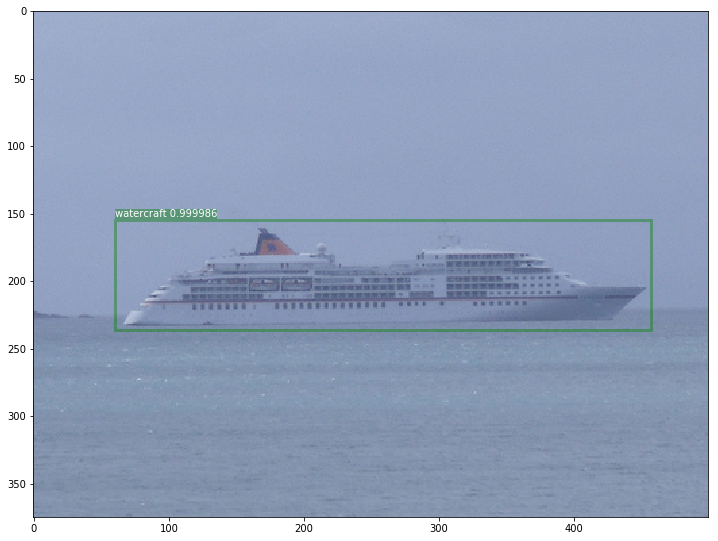

In [23]:
###Eg. output
showBoxResult(8800,all_boxes,imdb)

### Transform pickle boxes into Text format for evaluation

In [104]:
def Pickle2Text(picklePath, txtPath, imdb, threshold = 0.8):
    with open(picklePath) as f:
        all_boxes = pickle.load(f)
        num_images = len(imdb.image_index)
        print('num_images:',num_images)
        assert len(all_boxes[0])==num_images, 'Number of images not equal.'
    with open(txtPath,'w') as ft:
        for i in range(len(imdb.image_index)):
            for j in range(len(imdb.classes)):
                if isinstance(all_boxes[j][i], np.ndarray):
                    for bbox in all_boxes[j][i]:
                        if bbox[-1]>threshold:
                            item_temp = '%d %d %f %f %f %f %f\n'%(
                                i+1,j+1,bbox[-1],bbox[0],bbox[1],bbox[2],bbox[3])
                            ft.write(item_temp)
                            sys.stdout.write(item_temp)
                            sys.stdout.flush()

In [105]:
picklePath = 'output/res101/val/faster_rcnn_10/detections.pkl'
txtPath = 'output/res101/val/faster_rcnn_10/detections.txt'
Pickle2Text(picklePath, txtPath, imdb)

num_images: 20120
1 24 0.999072 112.380173 108.762726 425.096405 192.978287
2 24 0.995784 101.618469 200.946503 343.374512 289.832428
3 6 0.961078 81.676003 92.167709 492.475220 272.399261
4 6 0.868662 133.199997 149.532898 365.671112 282.164673
5 25 0.937554 37.863953 258.645966 131.640411 374.458923
6 10 0.998058 194.489746 323.992157 296.809082 497.729858
6 10 0.989402 83.454056 276.524384 168.270386 443.716888
6 10 0.969656 153.718872 276.921509 288.883179 402.248871
8 6 0.998670 142.591110 103.670578 407.598969 360.657013
12 27 0.845040 0.000000 32.421398 373.812164 122.797997
13 28 0.907112 74.680870 111.811874 397.112091 242.311844
14 6 0.997302 121.494637 50.365658 415.162170 389.855865
15 30 0.842924 112.428719 36.274925 367.794159 331.078705
16 6 0.996724 64.960258 58.527920 317.547424 288.720337
17 10 0.996235 61.341038 122.228699 390.996246 361.424103
18 18 0.929993 63.269890 9.742279 293.130554 491.353455
20 6 0.993814 31.050009 147.969437 226.132812 303.178162
20 6 0.9525

160 6 0.992114 133.002869 206.794724 372.052307 347.323486
162 10 0.998947 205.703888 22.159643 383.636932 203.993073
162 10 0.996403 63.130306 93.462265 221.557602 358.649933
162 10 0.989778 229.280273 156.966614 350.467560 364.912567
164 10 0.998725 255.009109 62.844902 499.500000 282.775452
164 13 0.964982 35.669949 40.985111 176.755920 232.603928
165 4 0.999503 239.712494 139.956207 359.073059 279.185455
166 6 0.993898 60.588955 171.285599 359.736176 403.349152
167 10 0.999669 137.439896 102.428040 367.289001 374.375000
168 10 0.999308 157.107758 30.914440 441.657654 317.780579
169 10 0.999665 68.977722 58.085815 341.023071 469.830048
170 28 0.985178 29.743481 243.173706 312.921539 457.382233
171 29 0.880205 266.622986 113.595085 327.030975 139.390259
171 30 0.996956 101.141869 84.125381 193.645218 215.736649
172 5 0.945177 130.139832 165.367249 276.291351 327.935699
172 5 0.824660 267.085419 150.712860 491.308136 314.528656
173 15 0.998430 70.189491 103.013832 396.594208 324.89648

298 6 0.983880 329.761292 150.347015 450.165619 405.867432
300 6 0.996756 12.406082 76.018448 428.935669 282.940674
301 10 0.998105 0.000000 70.296440 207.494827 499.375000
302 10 0.998077 21.036278 71.496468 491.567139 353.746613
303 29 0.991884 154.291275 11.850705 559.559265 476.701447
305 10 0.816685 144.932983 83.877090 333.731110 344.361023
306 6 0.994832 71.346436 125.219193 271.238770 429.912231
307 10 0.999290 176.419952 55.264896 332.688812 289.371613
309 6 0.997968 150.158020 142.583099 356.926788 323.929504
310 10 0.958688 84.736023 74.979851 445.006683 357.275604
310 25 0.883206 266.613983 103.513847 603.095825 433.153320
311 6 0.997605 161.080414 50.145561 386.393768 368.470093
312 13 0.846686 80.411934 99.762878 319.101624 243.983261
313 19 0.998318 55.880859 231.516830 209.849747 486.300446
314 7 0.941092 93.927963 95.448456 293.320953 417.000732
315 10 0.999200 205.668655 0.000000 383.615051 367.292023
315 14 0.913964 44.703846 187.569824 197.059494 353.429565
316 10 0

437 6 0.998635 207.181107 107.366180 434.315857 366.010101
438 30 0.997625 106.668541 95.469170 344.751740 265.815002
439 11 0.998227 166.790710 130.645447 333.444672 374.375000
440 7 0.801603 299.882202 192.772827 459.212708 356.979828
441 4 0.993730 141.526642 46.215004 210.561951 149.588440
442 28 0.929474 54.010563 90.027504 330.809479 349.534790
444 19 0.990572 59.741928 48.338650 248.249634 298.293335
445 6 0.997124 179.353455 114.826637 329.845367 447.258881
447 29 0.992297 290.734375 0.000000 886.480347 459.189056
447 29 0.811667 4.197295 439.132812 248.116867 518.644897
448 6 0.999058 323.320618 174.051926 379.990021 234.525650
452 28 0.849427 292.561249 83.136162 564.550964 426.632904
453 6 0.998038 106.696602 141.638718 278.480103 243.620483
453 6 0.991620 269.101013 137.889511 409.282837 249.967743
453 6 0.963616 109.152023 208.314590 254.810638 275.736053
454 10 0.998380 6.467513 57.851807 499.330017 316.948578
457 10 0.995709 88.082405 154.713318 431.122437 398.472260
459

575 6 0.998852 24.226757 28.747671 242.326660 252.081909
577 5 0.909173 400.042023 0.000000 499.174988 232.329620
577 10 0.999554 54.746544 126.839424 351.967987 456.950958
579 6 0.999039 110.584503 168.503998 233.187805 454.201935
579 6 0.981182 13.934746 183.258514 173.620636 472.157745
580 9 0.993001 66.257164 200.432037 231.467133 300.815216
584 6 0.998016 44.992714 113.248039 380.853699 378.499512
585 28 0.840521 66.089310 108.546852 456.676086 388.614624
588 10 0.999258 355.581848 143.085266 491.339966 294.100342
588 10 0.998984 30.792547 83.663170 197.381393 278.726044
588 10 0.993766 205.006546 147.912735 352.239136 273.301636
588 10 0.889852 193.115463 117.454750 300.569672 201.735428
589 10 0.999636 28.228222 174.953873 370.670013 487.999542
590 19 0.999125 5.338690 5.905689 201.746368 233.609985
590 19 0.978548 178.552826 132.158859 262.946960 231.025009
591 10 0.987644 156.634796 76.463478 450.300781 361.670837
592 18 0.899810 233.691895 130.203735 363.373962 233.782303
593

741 24 0.997477 21.741188 189.279541 392.226410 376.953217
742 28 0.990683 97.621574 372.873199 257.716614 450.209503
744 6 0.999207 42.199333 54.178734 365.113098 326.481567
745 13 0.997936 148.624695 67.537079 433.767944 306.912323
747 6 0.994969 210.485092 229.427048 294.361328 413.304779
748 19 0.997847 302.974426 51.526775 459.378784 282.734650
748 19 0.996669 14.037409 103.082489 318.577393 282.492401
749 24 0.987516 17.245710 113.070610 472.110748 280.973938
750 5 0.992502 37.684326 64.656097 227.645782 282.793396
752 10 0.999607 83.596504 25.261269 308.620453 361.139465
752 10 0.981028 267.726013 216.759491 496.826965 351.549438
753 9 0.999290 202.969086 117.157852 429.393646 290.969482
756 6 0.997786 164.054947 116.743759 332.364136 485.087952
757 27 0.858355 37.242832 14.216041 285.613678 426.405426
759 10 0.981673 0.000000 172.054138 401.472168 361.627563
759 10 0.900249 259.192749 204.502686 479.606628 367.294983
760 4 0.955463 0.000000 15.006714 280.963287 298.476166
760 1

910 6 0.997295 71.481453 148.629074 182.714127 425.095337
914 27 0.820253 86.294556 29.921906 396.354004 469.022980
915 21 0.803069 211.021500 417.865356 269.274597 472.156219
917 6 0.995922 94.506248 23.622580 241.488083 322.078735
919 8 0.966140 82.668991 118.440445 442.114624 241.776276
920 28 0.995201 191.121994 122.720039 458.544006 277.886108
920 28 0.987948 137.503616 90.450706 282.353699 212.138123
921 6 0.999189 84.247971 79.531158 389.665009 272.151672
922 19 0.994485 208.929825 141.211426 593.149902 588.302856
924 6 0.979108 130.138718 128.924713 413.270142 273.587280
925 3 0.999376 222.263168 151.791779 326.949158 271.040314
925 3 0.998553 116.676018 55.169266 179.342941 124.893105
927 27 0.879797 95.577568 42.961571 499.253326 327.611786
928 10 0.999684 0.000000 72.143600 423.991241 265.686188
931 24 0.992623 83.268097 23.078074 597.441162 416.322235
932 6 0.999059 46.643101 61.657097 338.600494 342.871979
933 6 0.929466 140.665329 70.716988 243.930237 134.212448
934 6 0.9

1072 6 0.806686 193.017197 84.104065 482.302673 316.756287
1074 6 0.850100 200.479187 213.445404 227.101654 253.989639
1074 31 0.921712 390.813477 58.945862 483.002655 173.807556
1076 10 0.996778 128.685745 123.581306 430.954865 288.599243
1077 6 0.997909 206.127304 91.030518 489.005493 327.434326
1078 5 0.846028 332.692108 83.033051 483.871002 374.375000
1081 10 0.999400 291.761230 152.363052 413.943848 323.922302
1082 2 0.806188 0.255229 55.713970 399.333344 490.814789
1083 18 0.994240 15.554306 114.768623 297.899414 447.460938
1084 10 0.999342 88.964569 47.955132 362.001282 357.328156
1086 10 0.996527 380.698090 122.169846 499.308380 418.301697
1086 10 0.983330 47.620525 41.852180 382.595642 418.301697
1088 10 0.998314 0.721805 123.893463 118.107834 358.401642
1088 10 0.997715 384.917877 97.888474 484.323456 325.077881
1088 10 0.993757 133.649231 122.138054 238.014282 346.150726
1088 10 0.987235 164.837845 124.292740 491.733063 333.872467
1089 24 0.994980 29.401569 67.057236 393.389

1232 8 0.841937 89.900818 9.216418 206.412384 104.422188
1232 27 0.881882 246.558807 18.053570 365.591675 152.937592
1233 4 0.935349 238.983307 209.329605 499.375000 368.863281
1234 13 0.965358 21.437773 183.539062 237.577011 412.343231
1235 24 0.986482 163.397446 131.533508 445.080902 370.397217
1236 5 0.992947 244.406235 151.193527 492.034607 319.604980
1236 5 0.989647 0.000000 165.653137 77.155708 267.106079
1238 8 0.817944 56.982628 19.379929 290.401886 205.369492
1240 2 0.976065 31.607344 60.050220 154.478943 97.148209
1240 2 0.961941 27.465679 121.883858 306.608551 425.322540
1240 2 0.954011 180.165619 103.589378 263.525543 193.906982
1240 2 0.904116 7.187911 314.175385 150.166245 362.658447
1243 10 0.998373 104.271622 196.900482 347.927826 393.726349
1244 19 0.982520 175.723984 43.823227 254.398712 132.104065
1244 19 0.964897 263.050293 56.466541 345.487579 160.892181
1244 19 0.949646 184.196960 37.890656 377.042450 325.913727
1245 10 0.989789 184.542389 68.582771 358.826569 350

1377 29 0.966365 0.000000 32.942543 486.866821 374.375000
1377 29 0.950309 2.265654 4.823246 139.229935 143.162643
1378 27 0.911054 176.223450 27.758547 484.260712 300.469940
1379 10 0.997311 86.319107 107.004318 840.340515 631.003845
1381 5 0.996870 68.240715 141.785141 370.315552 353.116699
1383 20 0.995564 8.952558 192.739029 335.706909 448.975006
1384 28 0.907921 143.952454 368.228607 253.383591 420.228821
1385 10 0.965225 44.814148 44.041660 320.268585 371.680298
1386 10 0.989075 58.796387 64.477989 392.871246 249.756195
1387 8 0.884359 177.266205 109.778702 253.757751 144.877258
1388 18 0.992019 55.989624 79.535980 427.761108 325.312469
1389 8 0.823399 0.000000 51.798824 150.223938 101.163902
1390 15 0.870125 10.191231 68.939438 342.379425 318.681061
1391 8 0.992607 226.583588 335.940674 301.501404 369.567749
1391 8 0.917370 53.900681 331.082001 104.655907 356.136414
1392 8 0.805594 21.247078 19.893711 465.224304 143.832306
1393 24 0.990590 80.975906 168.443634 318.836945 363.929

1538 30 0.961054 228.629333 270.362579 295.816986 309.820160
1539 6 0.999397 111.352013 124.554993 361.560822 356.020691
1542 7 0.992941 293.298065 204.298370 499.375000 337.821655
1544 10 0.989495 0.000000 113.995026 444.765045 253.583328
1545 6 0.997065 203.704971 140.967773 403.136292 235.084351
1545 6 0.990532 121.878883 164.638397 291.545593 244.787018
1547 8 0.888567 340.497253 172.725800 422.173279 232.066986
1547 9 0.998288 84.314293 175.822464 273.658630 294.004822
1547 9 0.914379 71.828537 169.989426 150.804184 272.180237
1548 9 0.996483 240.254120 151.537979 294.445465 267.772949
1548 9 0.996234 145.848297 156.395233 200.859924 279.674377
1550 29 0.949646 615.502014 106.402534 1512.278687 1135.661133
1551 6 0.997465 133.639359 72.674530 423.887024 397.660980
1553 10 0.997773 17.618294 115.834267 412.151520 364.670746
1554 11 0.841725 4.491034 215.932541 290.820862 472.963013
1554 26 0.883853 6.482792 212.748428 227.409073 457.330627
1555 10 0.997130 210.144485 67.502121 392.

1689 7 0.880375 34.813862 115.003662 374.375000 491.056274
1690 19 0.998267 257.342133 54.877907 476.306946 379.426178
1691 27 0.998973 61.904545 119.724174 413.487244 377.301056
1692 19 0.998044 181.551102 134.133255 350.114288 301.432526
1692 19 0.922163 91.802216 126.779274 491.454071 383.664856
1692 19 0.901281 182.484421 122.001060 250.373566 235.583633
1694 6 0.994707 151.126114 159.953949 278.159241 422.102234
1696 4 0.989871 34.530239 205.522049 180.825409 286.371094
1696 19 0.998757 158.525864 137.187271 320.309540 269.477509
1697 10 0.998314 59.894939 6.911637 240.854492 499.500000
1698 28 0.951060 11.410426 110.690872 488.619385 325.936401
1700 20 0.978035 258.221741 94.074562 499.708344 303.427643
1704 19 0.996299 99.199913 143.222961 360.634827 382.821136
1704 19 0.985691 307.509705 266.343170 437.635712 368.780151
1705 10 0.891466 136.376282 56.117294 296.182220 269.982605
1707 10 0.990271 133.083054 20.696011 371.606934 280.051422
1709 27 0.848095 420.849854 86.223602 49

1852 6 0.993903 116.015846 108.445885 375.711700 323.486572
1853 24 0.995332 212.385956 192.120041 472.880310 300.884277
1855 24 0.985601 22.289392 139.217224 464.891541 232.910599
1855 24 0.845887 241.842987 153.592239 477.964111 208.854416
1856 6 0.997092 91.567307 72.217911 379.884338 358.055939
1858 10 0.988192 0.000000 91.912811 291.880615 374.375000
1858 28 0.928297 338.752808 165.005661 467.318726 229.090179
1859 6 0.999006 74.051849 106.960464 321.580811 454.356079
1860 5 0.994828 86.741936 293.332703 183.462051 400.442230
1860 8 0.979857 196.979614 187.746109 332.445007 278.553925
1861 31 0.998035 233.045578 41.960106 499.333344 387.411621
1862 7 0.852478 0.000000 71.813477 399.556671 363.686005
1863 5 0.880782 258.323151 141.003357 476.963654 298.160370
1864 6 0.989842 191.403580 185.046768 339.089172 395.346466
1864 6 0.827490 348.675964 261.387756 461.433624 398.895386
1866 5 0.998982 3.297142 202.302551 309.094727 428.271149
1867 19 0.999079 91.990982 64.003944 446.674103 

2021 10 0.999716 14.068383 16.927046 77.254227 141.763321
2021 10 0.999419 75.266884 8.845271 190.134109 137.529236
2022 10 0.997832 176.069702 94.056931 392.697876 311.379272
2023 8 0.945080 101.312599 195.647308 451.295746 372.627747
2024 13 0.999016 92.083061 73.456284 424.517029 520.080688
2025 18 0.842082 179.892807 104.042320 493.393494 284.205017
2026 9 0.936342 213.700211 196.217621 337.369873 322.733490
2027 5 0.848106 0.000000 278.034393 312.403900 491.126312
2032 24 0.819497 209.188873 71.213562 390.745667 243.991669
2033 29 0.992050 68.821533 37.559166 296.864807 425.608246
2035 6 0.999595 106.650322 70.221474 455.505768 298.338898
2036 24 0.987031 74.199448 129.210831 346.056671 326.272736
2037 4 0.999565 138.866806 61.071136 232.575729 143.420547
2037 4 0.999266 3.770148 53.943142 141.066788 142.158737
2038 10 0.999210 24.042110 69.937660 194.696335 342.603577
2038 10 0.998677 155.887756 99.069412 401.266418 370.258331
2039 6 0.999009 45.266708 60.030811 432.235321 466.18

2166 10 0.998890 28.822765 8.929590 296.662781 379.140778
2167 2 0.810672 129.269623 43.274925 446.060181 303.125183
2168 14 0.996651 122.103966 21.712566 373.198334 333.443329
2169 10 0.990612 0.379237 50.044895 328.475159 328.757111
2169 28 0.955552 431.971954 260.104706 493.322968 326.252869
2170 24 0.913276 19.639805 18.432039 327.489258 416.882050
2172 10 0.945567 172.982803 81.947701 314.782288 267.781616
2174 24 0.959476 43.892422 192.906128 217.965027 417.981873
2176 8 0.973017 23.518887 90.098648 454.821960 281.251831
2176 8 0.952704 280.831482 97.386482 476.162018 220.210815
2177 6 0.913333 248.989975 129.520065 338.201874 185.252655
2178 6 0.993527 195.627945 111.544456 291.206909 292.289062
2178 6 0.979093 68.138580 100.494583 168.982376 275.960236
2179 6 0.997957 22.302616 132.254211 441.951691 365.971680
2181 10 0.998476 23.007723 227.422073 219.352219 400.804382
2182 7 0.996653 19.392052 126.078934 224.229416 271.945099
2182 7 0.995838 319.866089 111.126930 463.350830 23

2318 7 0.994669 80.843697 199.075043 481.823700 368.654724
2319 10 0.999577 178.043732 101.736633 335.292358 313.597168
2319 10 0.997715 1.727930 181.708542 218.206909 332.445007
2322 6 0.997711 96.167801 101.538124 452.828278 302.078033
2323 10 0.999240 167.697601 24.060631 486.172485 374.375000
2323 10 0.998268 34.709381 153.294250 174.629227 345.728210
2324 28 0.983900 30.483511 132.346848 339.011841 356.046539
2325 6 0.976771 197.411697 62.989773 439.839905 422.294983
2326 4 0.999144 106.994888 3.510999 188.282181 124.204613
2327 18 0.872696 13.773515 88.406120 443.630066 261.008331
2328 28 0.829410 35.108147 72.119598 357.546234 306.069336
2329 3 0.999694 76.079674 191.595001 314.412048 352.285278
2329 3 0.998595 97.124252 89.676819 228.226196 179.879608
2329 3 0.949233 99.674873 112.824249 277.030334 274.164856
2330 6 0.989881 162.379395 19.842684 416.661102 374.012512
2341 10 0.999408 67.552917 171.236908 283.157898 374.375000
2341 10 0.997986 255.705688 57.081814 476.363190 374

2477 29 0.967212 0.000000 57.776699 198.181885 227.803223
2478 19 0.999570 44.484749 22.376484 465.516449 472.179626
2482 6 0.990514 205.118240 18.243675 330.210815 429.975128
2483 19 0.972584 140.659012 115.945297 225.548935 230.227509
2484 10 0.820800 47.303028 124.638229 499.500000 273.870117
2485 10 0.993682 67.781548 121.424408 255.602814 485.951813
2486 10 0.997567 140.040955 114.868477 418.535522 335.478210
2487 28 0.932420 203.812683 78.419174 471.207611 281.037659
2488 10 0.999458 167.675751 69.051544 488.511017 324.825836
2488 10 0.993809 0.000000 0.000000 298.463715 314.519623
2489 19 0.981833 359.236298 214.002258 432.511536 340.587097
2490 10 0.997679 57.887230 146.413956 405.468994 313.740509
2491 19 0.897386 104.594147 129.982285 382.272156 274.230682
2492 6 0.998695 52.939049 57.492798 269.804260 499.333344
2494 24 0.951927 258.364624 55.215523 490.779175 255.073395
2494 24 0.803955 34.403019 43.872063 429.169464 359.450134
2495 10 0.995606 58.611553 236.288895 234.7373

2641 10 0.954311 242.019043 190.961517 488.747711 364.756470
2641 13 0.827527 220.954712 190.829132 494.183014 366.748474
2642 6 0.999009 301.198486 312.462646 399.497742 399.182373
2643 20 0.968560 3.072529 153.393311 472.576141 361.924622
2644 30 0.989460 242.100464 10.449770 426.061493 137.255371
2644 30 0.836262 51.499615 67.881821 294.045502 136.803543
2645 10 0.997484 92.715172 73.347420 401.809692 285.306030
2646 10 0.999737 179.009628 31.743446 376.132965 328.784332
2646 10 0.998696 21.067684 35.457321 237.818024 333.890564
2648 11 0.990474 37.454865 152.233734 304.271820 434.256531
2649 27 0.860821 0.000000 194.157379 245.791168 361.929504
2649 27 0.852880 17.785530 88.812668 499.375000 361.118530
2650 2 0.827863 0.000000 102.751129 480.775848 295.939514
2652 8 0.985153 61.094116 124.181786 499.330017 253.275009
2653 8 0.888373 94.796906 131.928360 635.880005 462.783417
2654 24 0.971848 193.953629 106.537338 475.911041 190.460327
2655 28 0.999074 72.270691 31.621569 439.299866

2781 6 0.998986 174.912384 132.461243 359.312775 241.175049
2782 6 0.998164 134.002090 87.548866 347.797577 344.603729
2783 7 0.959431 1.995937 53.068802 493.078949 306.897705
2785 8 0.851742 122.525291 176.468582 304.501953 305.084778
2786 5 0.982377 85.584251 261.530090 282.734070 335.952911
2786 8 0.987071 18.668203 109.887451 116.441109 156.893906
2787 6 0.958209 58.692509 181.325226 229.079010 277.484528
2788 6 0.998206 0.000000 13.062820 341.784790 269.178894
2788 6 0.966157 218.979889 246.722107 429.704895 370.063110
2788 6 0.921037 193.694138 30.807838 466.234589 356.446991
2790 5 0.999623 86.123314 152.869400 485.543701 344.169617
2790 27 0.845596 11.541929 50.015774 248.427811 114.690094
2791 28 0.999293 271.331787 272.766449 1018.178345 651.455383
2792 8 0.915784 0.000000 30.086399 124.381012 136.384644
2792 8 0.912431 22.792149 49.784668 499.375000 357.970764
2792 20 0.927714 7.650623 59.176636 499.375000 359.564850
2793 2 0.838345 0.000000 107.856598 460.277649 238.467255


2917 6 0.997252 142.504150 103.028610 399.477417 309.438904
2918 5 0.857859 114.435280 181.459991 347.639557 366.388306
2919 6 0.859288 352.548004 24.745544 450.010864 231.538803
2922 10 0.961467 161.065536 41.756725 426.059570 339.240875
2922 19 0.855310 156.421082 81.502106 418.149414 346.957397
2924 6 0.996757 393.914001 131.181168 499.375000 238.576569
2925 10 0.993871 135.701355 170.801117 499.375000 316.034058
2926 3 0.840783 14.039871 97.053085 287.018097 296.934967
2926 10 0.988431 37.432045 100.177170 300.829468 291.525085
2927 30 0.959558 199.727356 99.169731 377.026611 214.557373
2928 6 0.995801 340.765106 96.024887 468.063934 172.261505
2930 27 0.954248 18.400097 104.115311 499.375000 329.044800
2931 29 0.995655 5.426826 32.202549 403.131226 311.634125
2931 29 0.833447 0.000000 166.669647 183.402374 355.603027
2931 29 0.819485 0.000000 7.810669 197.657776 206.045624
2932 18 0.961528 58.767544 158.788803 415.426788 384.307068
2933 2 0.986095 328.145508 124.392548 1540.005981

3069 10 0.913502 17.127110 32.637489 252.271271 274.917664
3070 13 0.999460 150.657837 62.234436 303.656311 204.845047
3071 19 0.999648 97.243156 71.912758 491.644653 370.914551
3072 12 0.998499 188.944977 228.438599 386.621002 449.691528
3072 12 0.956555 717.694580 309.950684 843.047974 383.257446
3073 6 0.998916 22.766037 140.533020 366.884308 333.267487
3074 10 0.999773 102.792313 41.948757 371.661377 368.384552
3074 10 0.993191 428.956451 112.214615 499.375000 335.021973
3075 6 0.999170 199.005051 127.089859 292.439728 229.732956
3076 29 0.995230 0.000000 83.309799 499.375000 244.402100
3077 16 0.879419 112.929062 94.313293 459.384003 234.933533
3078 6 0.999235 163.800049 185.324631 318.526001 359.694885
3079 28 0.934290 351.391083 293.324066 452.435059 411.712250
3080 10 0.988357 296.428650 97.489990 480.764648 369.719543
3080 10 0.987953 53.568047 56.752434 159.622757 237.147308
3081 15 0.951245 358.994293 332.859375 393.160095 362.531555
3081 15 0.944001 308.456970 333.142517 34

3226 8 0.988836 65.033379 204.039291 134.616455 234.163040
3226 8 0.810892 151.875702 167.355469 243.524307 216.903046
3227 6 0.997972 202.179474 234.053894 393.018738 381.099091
3228 30 0.905716 4.923210 125.680756 430.484436 363.865112
3229 10 0.999528 4.249792 7.723408 243.177063 355.105591
3231 5 0.941103 38.654240 255.859894 373.376678 493.599945
3231 5 0.908318 201.558029 43.893021 251.780426 123.873375
3231 5 0.845961 103.355110 18.291399 176.762970 68.887993
3231 10 0.977649 49.286572 46.554276 262.215729 362.403503
3233 8 0.857236 3.818283 126.407936 118.034348 178.804337
3233 24 0.974847 86.089096 113.611008 451.923218 305.035950
3233 28 0.979867 130.387100 23.074274 489.566406 339.334686
3234 7 0.949779 151.678391 150.323441 466.895477 326.305206
3234 8 0.988601 0.000000 197.422211 134.441559 317.834106
3235 9 0.993704 46.484119 162.884293 250.207977 334.270355
3235 9 0.962098 161.868927 153.176270 345.598907 329.061554
3237 6 0.986865 122.899124 61.880451 444.039307 410.315

3378 6 0.935564 172.687134 14.736919 244.776443 129.153732
3378 6 0.862115 91.327095 83.066772 206.471588 139.314911
3378 6 0.832702 212.141968 287.088135 413.105927 329.642334
3379 10 0.999642 178.514862 105.160286 499.375000 374.375000
3380 28 0.991930 30.217402 118.025963 419.412598 325.527710
3382 24 0.994627 27.740440 167.222061 278.585571 434.067688
3383 17 0.986406 0.000000 48.133812 539.908875 384.459869
3384 10 0.993463 62.213768 170.512238 204.365723 421.096771
3384 10 0.986295 166.376617 152.627014 308.086700 393.908264
3385 10 0.998172 222.866501 202.237335 727.899475 1129.950439
3386 19 0.989013 237.039505 136.699219 399.397644 265.019806
3386 19 0.921322 247.315613 160.102859 310.955780 233.000809
3387 24 0.977226 4.206334 102.230164 440.293762 351.657104
3388 30 0.811504 14.056850 31.263058 115.256012 67.288765
3389 29 0.960189 25.542471 96.700638 453.872162 324.893188
3392 18 0.938519 0.000000 97.692833 466.235199 231.643097
3393 6 0.999785 63.551208 62.462551 490.74493

3536 24 0.977910 63.535786 43.410854 235.678085 479.078369
3537 19 0.938184 132.165558 37.981525 355.406158 332.445007
3539 6 0.999646 145.844757 66.116638 409.830750 262.105743
3540 6 0.999668 300.284119 299.798187 361.913239 386.599854
3541 7 0.996439 2.025569 91.962807 476.695374 271.952057
3541 7 0.951944 0.000000 111.502243 100.892151 217.064255
3543 10 0.999006 16.801405 33.957424 270.391937 216.784653
3544 10 0.992666 45.485870 236.228394 172.544754 358.904388
3545 6 0.997754 15.097164 225.931000 329.636871 396.971466
3546 21 0.996018 16.848604 70.721893 79.965370 116.824638
3547 5 0.979889 0.000000 139.586243 438.945770 366.763123
3548 2 0.998878 16.304249 126.897743 470.012604 284.702972
3550 18 0.989802 104.167007 143.057083 499.375000 352.810608
3551 6 0.997943 161.313187 136.183014 367.217346 257.695068
3552 11 0.993131 59.171906 102.610451 340.689575 255.007690
3553 14 0.833200 385.688660 47.224701 493.840057 267.188171
3553 28 0.997933 48.344009 54.912052 363.303528 338.9

3680 6 0.995314 72.626930 138.276703 426.254181 329.966949
3681 2 0.898825 17.430401 96.743996 489.979919 268.127716
3681 8 0.821617 84.508514 111.551041 494.273315 245.645737
3683 5 0.955350 0.000000 109.035950 434.567230 384.059174
3686 6 0.998935 122.136597 123.048592 298.321350 374.375000
3688 10 0.999845 67.905212 43.685856 283.019012 455.176636
3690 8 0.823907 551.199585 327.018494 714.012512 443.474182
3691 11 0.997328 219.979248 87.643097 432.290588 240.566788
3691 11 0.978917 141.881287 129.951065 227.427948 221.273621
3695 4 0.998309 73.228508 70.256645 281.849060 185.034836
3699 8 0.928177 18.677794 23.182907 222.169586 130.633133
3699 8 0.887253 0.000000 159.907593 239.679993 206.773254
3700 29 0.984891 51.704556 155.378998 203.349060 240.525391
3700 29 0.959981 0.000000 117.044937 470.434570 249.876434
3700 29 0.918260 233.057434 304.485535 262.714691 337.109314
3701 28 0.986122 62.104778 100.780777 487.390381 294.712097
3702 19 0.999101 185.776031 83.295326 280.368927 227

3833 6 0.997699 55.769707 258.736603 339.158539 412.939331
3834 29 0.991336 9.294949 159.352859 364.875244 260.663391
3835 6 0.977813 74.066963 78.493721 449.006012 362.789642
3836 10 0.998689 84.580627 43.183617 420.321289 315.800629
3836 10 0.981750 73.840256 178.640610 234.769653 315.677673
3838 6 0.997128 206.522385 45.683361 467.902954 200.870895
3839 8 0.993596 400.723755 194.621857 472.952240 248.750793
3839 16 0.999305 17.796011 114.956200 237.151718 312.154785
3842 18 0.899978 205.839340 110.268127 425.813599 266.564270
3843 24 0.988054 91.640656 108.012177 384.956024 335.098572
3844 6 0.998264 147.002319 177.854919 334.686035 290.674469
3846 27 0.997868 67.019569 176.098572 205.012482 292.576538
3848 29 0.958364 93.419853 230.285446 472.327454 413.525177
3850 28 0.834712 25.996065 254.685135 405.029968 443.741425
3853 28 0.823573 84.811447 62.908409 433.984924 290.996307
3854 5 0.923065 66.602905 45.161758 498.486298 333.443329
3856 8 0.881318 0.000000 49.429024 483.556793 34

3992 27 0.947700 226.541138 79.227142 472.159149 187.937057
3996 2 0.858574 38.921089 73.527489 433.517151 318.980774
3997 10 0.980182 64.874199 141.120956 296.644623 321.602783
3998 28 0.985734 39.497765 78.604233 433.074066 313.967010
3999 10 0.990968 204.241867 108.858017 406.939941 338.148346
4000 6 0.999193 201.931152 217.152328 326.245789 360.469604
4001 18 0.962774 115.008835 92.081497 472.591187 296.231140
4002 10 0.999818 86.378998 68.878609 369.631195 289.200897
4003 10 0.957944 33.521538 102.347885 442.777832 303.755157
4003 10 0.951222 269.418365 61.880051 439.463470 218.749603
4004 27 0.982862 2.800484 93.033157 451.177399 325.704651
4008 9 0.869241 271.862549 245.673386 306.684387 271.450958
4008 31 0.998684 58.435566 296.595673 212.983231 458.639679
4009 30 0.992343 179.867920 206.652557 236.332626 252.494125
4010 13 0.999807 78.541512 89.667953 655.178162 316.403351
4011 10 0.999732 261.599457 2.983112 474.272095 372.041077
4011 10 0.998526 81.232918 101.914902 206.7784

4143 10 0.998049 84.094620 109.577629 254.300842 482.093872
4144 6 0.998114 82.782349 43.464043 203.056259 306.613312
4144 6 0.995952 221.100769 72.568092 425.148254 357.265350
4144 6 0.867806 137.236191 42.673721 314.503265 319.426392
4145 29 0.997016 0.000000 0.000000 408.223846 227.930634
4146 6 0.994297 201.849930 84.400421 451.717285 403.124115
4147 2 0.848300 200.410629 248.820908 277.326904 296.129822
4148 13 0.932227 60.244278 78.760300 409.820007 268.830200
4151 10 0.999839 63.081207 8.079052 499.375000 368.263092
4151 10 0.814430 0.000000 147.056168 344.142487 320.000122
4152 6 0.993458 148.136154 47.992546 417.238892 305.823669
4153 6 0.997637 90.403717 116.935295 384.549927 398.153961
4157 6 0.999246 275.297974 132.006302 417.783569 208.585480
4158 6 0.999361 106.294029 93.926346 403.146179 271.303589
4159 29 0.958415 284.393555 51.952709 419.677582 167.354660
4160 6 0.998839 139.380524 266.083252 399.586548 438.258240
4160 6 0.997877 144.894272 55.534058 395.349792 225.320

4312 8 0.875375 216.449005 35.693966 492.899261 190.770187
4312 20 0.907011 8.732250 182.363190 247.181412 349.038513
4313 20 0.871816 0.000000 286.079498 216.319061 463.899689
4314 25 0.998879 75.406158 169.291000 255.001480 325.774933
4314 25 0.803602 160.111389 167.847076 310.599335 494.056976
4315 19 0.850673 3.878081 62.809258 277.702942 499.500000
4317 6 0.842858 147.705460 120.940941 275.122345 327.296570
4318 10 0.998269 116.661980 110.275681 425.087585 338.861725
4320 6 0.998970 87.146202 155.339981 312.003052 385.127686
4322 28 0.854032 63.906349 79.841454 466.326294 332.445007
4323 6 0.998419 150.228760 110.013802 290.270691 297.938629
4324 28 0.948030 40.444450 203.249237 479.276245 374.375000
4325 10 0.998133 11.627748 108.558884 426.878052 385.356659
4325 10 0.900303 245.929703 69.343071 479.323914 304.752106
4326 10 0.996451 90.608353 114.528351 259.789856 499.375000
4327 10 0.999940 57.453823 33.182854 449.671295 386.821045
4328 24 0.997755 161.966537 168.538666 488.685

4471 6 0.999014 140.096359 110.164413 387.486237 281.533020
4472 4 0.973959 116.720421 196.417923 295.118683 329.886230
4473 29 0.834500 103.761047 149.212463 396.716827 258.408112
4476 29 0.993484 60.264492 48.427811 441.665100 274.427826
4476 29 0.959020 157.661636 272.762756 323.770477 336.697998
4478 24 0.989779 43.769897 216.990524 449.845825 492.508698
4478 24 0.989507 275.713531 259.503937 420.655792 473.766327
4479 8 0.800712 10.315797 15.198607 499.330017 238.658401
4480 6 0.993424 181.142639 109.803841 326.049164 219.316147
4482 5 0.965565 301.492584 145.701828 457.630157 322.260376
4482 5 0.961532 13.273169 173.620239 239.053162 325.619232
4482 5 0.881460 0.000000 61.493725 488.700531 332.445007
4484 10 0.985272 21.609810 249.775864 365.130920 557.573608
4486 27 0.915369 33.364182 156.075470 337.680664 473.836182
4487 19 0.965949 71.594666 148.810669 311.477356 386.090179
4488 29 0.959112 0.000000 162.546631 498.873352 285.987427
4489 10 0.997383 2.368660 41.175194 499.37500

4635 24 0.805816 181.587601 267.080261 283.138336 411.677887
4636 10 0.998998 68.866257 86.066010 400.281067 374.375000
4637 8 0.956693 428.357941 78.225273 499.166656 145.607117
4637 10 0.976361 141.613464 195.447205 407.665741 396.508362
4638 10 0.999895 41.295818 93.691788 187.763840 458.325104
4638 10 0.999205 192.315735 100.711998 327.707123 482.345490
4639 24 0.917984 193.671585 70.734810 317.985565 220.808121
4640 3 0.999615 111.761322 27.083588 499.375000 374.375000
4640 3 0.994283 6.640120 170.176697 88.682785 346.587067
4642 6 0.999375 103.589470 90.241440 423.692322 314.439911
4647 13 0.925106 116.500916 77.880058 422.000916 328.088379
4648 6 0.998410 219.833939 152.028992 361.690765 289.419464
4650 28 0.972701 228.755066 105.334473 318.520477 199.971802
4651 10 0.995219 44.661823 98.745102 337.423584 325.346405
4652 28 0.816215 113.087074 113.967857 339.985413 343.470795
4653 2 0.977175 10.293159 232.815765 165.120087 286.102692
4656 7 0.994133 4.518034 108.807831 306.46871

4805 2 0.999456 176.766281 97.621780 329.299377 157.705109
4806 10 0.999774 35.087700 89.409447 480.915680 362.044434
4806 10 0.942882 352.837677 181.987000 489.066467 319.356354
4808 6 0.995990 103.862190 117.632492 415.656158 345.278290
4809 10 0.996587 74.744225 94.218254 277.217133 259.986084
4810 6 0.996393 183.498077 55.165314 308.107910 289.951996
4811 6 0.997943 122.779381 39.516075 342.996643 424.549042
4813 12 0.997274 76.185585 45.687885 477.251526 249.850784
4815 5 0.903781 95.297096 318.968140 294.557800 486.311584
4816 10 0.997728 118.080917 37.824306 488.117737 374.375000
4818 28 0.810051 65.452698 265.931122 255.380020 479.766724
4819 7 0.999169 36.674480 83.848991 499.375000 265.569580
4821 6 0.995956 181.901901 170.930099 331.034912 303.695923
4823 28 0.966523 91.174675 115.514526 494.197876 358.810059
4825 6 0.998740 72.578995 46.814758 293.815674 150.264633
4825 6 0.978037 283.505798 81.203506 448.775024 177.061310
4826 2 0.920907 186.372711 134.252716 338.328094 24

4965 5 0.889261 280.540222 143.580307 415.249268 195.469421
4965 6 0.925519 205.468674 167.393036 233.605377 203.486664
4968 5 0.932202 114.864532 137.459122 247.475555 221.552109
4969 2 0.930818 221.125336 79.756409 381.470245 367.981323
4970 6 0.996482 135.686844 91.144577 451.611084 346.286560
4971 8 0.990105 0.000000 200.613708 123.098511 267.725250
4971 8 0.981358 320.586304 198.243851 378.393860 250.692459
4971 8 0.874350 405.433289 208.097305 474.501953 244.867096
4971 8 0.848859 129.026840 217.005157 174.498581 245.288239
4978 6 0.984137 110.356819 217.505157 335.273132 483.686035
4979 10 0.988670 93.276062 48.781178 244.855423 157.585205
4979 10 0.945298 47.140381 73.903419 141.542130 163.694153
4980 21 0.981501 88.897552 103.387253 426.624481 345.262115
4985 10 0.999394 88.831108 136.309937 298.309784 410.539001
4986 28 0.980498 119.416443 128.982239 304.868469 287.528168
4988 6 0.997406 159.161469 158.511978 477.437164 328.251953
4990 24 0.983753 138.894775 112.232689 337.68

5116 4 0.894015 69.213943 137.814285 165.204880 322.223267
5117 4 0.999520 157.607422 74.077133 353.272614 290.220184
5118 28 0.830801 222.201660 125.238365 394.542572 266.878265
5119 10 0.998179 182.597275 58.157890 342.646820 341.877319
5120 8 0.994040 74.227524 132.595108 471.653168 329.161072
5120 8 0.966759 418.968475 137.767578 499.375000 226.416794
5122 5 0.998463 125.884712 173.899857 439.755737 365.390015
5123 27 0.933574 63.272743 15.279484 328.481018 499.375000
5125 6 0.999182 76.957321 33.582333 347.155304 355.672668
5125 24 0.887283 274.895813 145.143906 486.969391 391.049591
5127 10 0.995595 61.847858 99.623169 412.263855 371.625519
5127 10 0.873398 309.783783 126.841873 407.366791 254.007706
5128 6 0.998890 129.586288 91.977226 479.637238 275.953156
5130 10 0.998264 127.295380 42.128357 372.264160 386.124695
5132 24 0.998628 65.145798 62.871452 415.952454 492.899750
5133 6 0.847197 168.243774 3.983577 250.599152 133.431290
5134 10 0.999872 134.813965 59.016743 354.256317

5276 10 0.997793 43.945084 194.029572 291.303253 462.955444
5277 10 0.999598 11.092682 31.261578 414.229187 368.301392
5277 10 0.985800 323.992157 63.011124 491.240540 371.381104
5278 18 0.965865 148.144241 155.119034 441.469482 322.531372
5280 6 0.996893 236.873245 63.781391 406.085083 359.036987
5282 6 0.998791 59.076111 125.990913 337.027313 258.283936
5283 6 0.998715 41.031631 224.715363 233.091049 382.862823
5284 5 0.877853 67.134109 70.773880 390.972534 353.126465
5285 6 0.998871 15.914650 90.700722 353.448425 214.415741
5287 10 0.982815 64.249687 139.171661 243.345016 470.053101
5288 19 0.997758 162.355576 103.600433 346.666992 355.466370
5290 10 0.998420 38.419754 129.710709 273.226288 466.889008
5291 24 0.993152 23.985302 265.527039 294.105621 469.283020
5294 10 0.998687 89.312286 84.289375 373.350647 308.816803
5297 10 0.997214 67.023651 132.925293 284.361023 495.896576
5304 28 0.885338 156.864029 104.138504 376.288605 262.045837
5305 12 0.998113 48.618145 81.388634 343.39382

5436 10 0.997207 167.749435 20.200684 373.497498 286.265808
5438 27 0.982899 35.361694 107.543587 474.665314 247.552490
5438 27 0.921136 0.000000 122.710251 128.379318 215.223175
5439 16 0.998212 202.365570 18.851200 401.095032 332.445007
5441 6 0.894367 0.000000 18.333036 450.010986 335.748260
5442 10 0.999519 168.611145 89.263870 348.010529 305.512665
5443 4 0.999224 126.176575 67.003609 214.902664 114.617714
5443 4 0.994798 0.216017 5.318888 112.399826 120.949089
5444 19 0.996690 97.273499 150.586929 256.913177 296.087585
5444 19 0.994310 286.398254 51.909256 397.308807 258.483368
5446 10 0.825825 62.832203 118.986847 344.600861 269.228546
5446 19 0.840923 38.617748 111.087540 337.489838 292.074463
5448 29 0.940931 0.000000 115.115952 499.375000 246.228851
5449 10 0.999580 266.179260 71.372765 427.924561 291.094421
5449 10 0.968351 72.431877 111.023575 368.466553 321.258301
5450 27 0.895747 68.395004 22.212486 490.241852 311.146606
5452 6 0.995895 308.311188 160.484741 381.773834 32

5573 29 0.925657 274.738098 178.567947 468.391479 249.699951
5574 15 0.840627 40.803635 156.950546 328.880798 481.692444
5575 10 0.989841 205.566223 104.487137 398.686584 300.943787
5576 10 0.999616 137.272263 77.755363 370.053680 234.076309
5577 6 0.999465 205.493347 159.882050 286.333252 296.529724
5578 6 0.994435 116.270889 121.086296 379.768677 415.743896
5579 6 0.996138 173.283844 103.703232 487.839081 292.225342
5580 8 0.994888 46.207466 145.241806 483.324615 269.292175
5580 8 0.877616 0.000000 165.616425 40.824829 198.249695
5581 10 0.998342 175.292526 59.216290 375.246216 306.105835
5582 6 0.868301 25.496349 45.516930 437.204895 363.834412
5583 9 0.970307 2.283363 119.761658 212.784149 355.641968
5583 9 0.963392 186.279022 131.216003 309.117462 343.977844
5587 10 0.946820 137.058075 27.764454 417.296021 334.314117
5588 19 0.997734 144.425766 58.998306 355.266541 332.445007
5588 19 0.850283 66.374092 49.465492 211.985001 332.445007
5589 5 0.812914 52.845592 112.288231 470.374634

5733 6 0.817404 206.577744 147.988022 439.432465 241.019882
5735 15 0.913787 128.610733 64.831383 423.803558 278.292419
5736 10 0.998493 13.263480 63.294140 565.585449 434.783905
5738 10 0.997407 137.066269 39.866264 472.111450 355.702576
5739 10 0.990157 152.251053 87.841385 400.002838 206.938965
5740 10 0.997452 23.101578 0.000000 430.925964 374.375000
5740 10 0.923498 356.811798 18.536234 496.458252 183.538635
5741 5 0.873499 90.656013 326.817322 277.983246 490.496490
5742 10 0.999626 39.810177 77.367867 336.523895 257.903046
5743 10 0.935830 2.098160 152.506805 401.717896 367.973358
5743 13 0.835194 11.167583 119.105042 412.996155 352.832703
5744 10 0.999169 64.967110 121.630157 305.895569 463.500366
5745 24 0.996017 81.660324 66.389610 434.141693 323.056824
5746 5 0.907322 135.441162 146.841339 321.226379 324.995056
5747 5 0.868437 141.119400 169.270142 362.761108 284.018524
5747 8 0.873225 0.384617 73.671249 118.132584 171.781677
5748 10 0.999432 132.329819 70.894409 332.542908 3

5882 5 0.997786 31.414059 107.148460 414.752045 289.720856
5884 18 0.956255 216.390778 213.856171 364.805908 385.098785
5885 10 0.921057 133.929733 253.249802 363.888306 359.863831
5885 20 0.971149 168.731842 65.889984 348.310974 239.912155
5886 6 0.997884 150.052307 70.360825 298.572662 334.483124
5887 10 0.998878 122.105515 98.217865 397.239960 374.375000
5891 10 0.999914 143.153885 89.609383 363.439636 207.000259
5891 10 0.999688 59.279140 102.653664 143.821442 202.258575
5893 24 0.952223 35.336349 58.808331 358.203735 254.932266
5894 10 0.999227 170.662415 106.060822 318.959534 362.250549
5897 6 0.984490 306.755219 189.932053 354.861450 255.850433
5898 3 0.895898 194.266022 202.203705 248.171051 247.870209
5898 10 0.958225 141.234604 273.192505 374.375000 444.697113
5898 10 0.948115 81.444023 251.220520 188.096649 440.384796
5899 6 0.978921 267.477081 89.302048 495.931366 211.580902
5900 6 0.996842 62.813274 103.152145 354.123627 420.581512
5901 10 0.995617 115.399628 50.890808 371

6026 6 0.996958 104.980705 80.497932 370.301758 231.790649
6027 5 0.998609 59.056747 125.751945 405.421448 282.046875
6030 10 0.998315 225.606720 21.855745 431.891144 334.792450
6031 28 0.970987 194.802185 239.017334 359.573730 391.511536
6032 8 0.935741 58.201511 106.155869 388.311401 307.669037
6033 8 0.803128 262.067963 60.621593 499.330017 236.476349
6035 6 0.999003 196.612701 38.798409 395.694946 326.967743
6036 5 0.995135 389.497650 263.634521 484.287079 340.051727
6036 5 0.974274 225.656509 257.795441 455.614380 342.652008
6037 6 0.986448 57.927029 25.049679 209.327988 133.977005
6037 6 0.977909 229.494003 244.580276 391.020142 337.457336
6037 6 0.945224 4.811473 156.577652 213.898163 239.982407
6037 6 0.881940 387.935791 71.440521 493.300171 175.903259
6037 6 0.809237 268.615265 206.193665 490.395935 262.186523
6042 8 0.920283 0.000000 185.109985 57.911972 212.007721
6042 8 0.844163 147.781738 128.294861 409.419525 268.212219
6044 8 0.966008 0.362492 120.658897 61.565720 168.05

6172 13 0.997758 242.569870 117.613632 430.522461 328.395050
6173 27 0.836133 0.000000 0.000000 499.500000 330.273315
6177 24 0.908606 120.854988 11.234055 496.497803 249.134140
6178 27 0.890401 122.714355 697.719299 938.892090 1152.769287
6179 6 0.998561 157.175095 139.900726 387.979004 353.978577
6180 28 0.808924 143.785461 122.306885 348.757935 298.831970
6181 10 0.981948 103.765709 31.301622 377.497406 326.881226
6182 10 0.998894 175.577667 70.122398 452.540039 331.446686
6183 28 0.929604 18.184490 18.532753 473.944916 411.940338
6184 2 0.867678 91.498848 31.623594 399.320038 251.431076
6185 22 0.959999 214.976318 129.329666 282.759338 262.828583
6186 10 0.999459 110.688644 18.098202 355.975647 374.375000
6188 6 0.994864 193.695297 63.715553 478.468994 323.329041
6189 24 0.996070 108.679489 118.329094 382.728333 373.252289
6190 6 0.999094 87.201279 241.713440 371.328796 388.013519
6191 2 0.846126 110.053215 126.440933 393.138031 217.017044
6193 2 0.914902 162.167053 156.082550 345.

6343 10 0.997941 98.039284 148.588715 279.340668 452.016968
6344 10 0.999151 200.977814 12.651691 454.712097 367.299255
6344 10 0.993448 1.964407 247.548294 260.510437 371.885376
6345 6 0.976948 251.706879 117.766327 399.205292 302.167328
6348 8 0.999371 0.000000 227.925690 625.690613 428.074219
6351 2 0.997974 0.000000 117.266785 499.375000 294.729706
6353 10 0.999425 89.784691 129.990417 309.360352 499.375000
6354 24 0.903867 248.481445 62.673298 378.643066 183.152237
6355 29 0.988185 209.992493 57.151501 343.458344 228.893906
6357 6 0.998071 129.989120 112.004272 458.768585 334.879120
6358 10 0.992266 133.586960 135.039810 499.375000 353.728577
6360 10 0.997147 82.051735 85.925049 403.511902 428.647400
6361 6 0.998092 304.156219 106.472862 436.279999 228.820175
6363 6 0.995882 117.762489 188.153152 382.565155 465.727417
6364 24 0.991767 1.642981 150.358002 314.032410 274.557770
6365 28 0.802001 70.760445 94.517487 356.077301 389.863159
6367 28 0.856833 61.193642 145.588196 299.01251

6509 28 0.999381 76.476852 80.648361 329.967804 348.706360
6510 8 0.856111 34.087715 140.808350 410.196533 276.469360
6511 8 0.873863 5.722103 170.248779 390.111328 345.895538
6512 24 0.958626 30.930103 336.261536 420.920410 623.442566
6513 5 0.946612 113.417519 201.619476 422.254272 478.946777
6514 16 0.922007 66.196884 122.682976 431.488983 496.117645
6515 10 0.999760 122.571609 143.424484 422.972595 365.050476
6516 10 0.998960 110.794640 132.093430 474.499878 374.375000
6518 5 0.994639 118.848503 309.782776 303.722076 476.044464
6518 8 0.821303 294.901306 262.411499 328.648224 306.047791
6520 24 0.917017 40.068123 102.132317 291.736572 441.923187
6521 28 0.962299 113.503014 132.932144 252.244156 273.624390
6522 26 0.987361 72.882256 129.268738 150.568451 199.095657
6524 19 0.925421 78.564903 6.089368 400.925232 424.276245
6525 10 0.991480 165.930298 57.170021 314.532013 367.468994
6525 10 0.985545 0.000000 83.397133 174.990051 374.375000
6525 10 0.972999 228.826889 79.347061 490.879

6659 19 0.999401 201.754166 84.506729 464.535980 370.251404
6659 19 0.998811 0.727262 97.701790 223.620117 372.339325
6660 10 0.998305 89.738091 91.662941 286.728638 466.885651
6660 10 0.846605 100.685432 345.696106 279.488220 484.602356
6661 28 0.879906 115.889755 17.017384 446.199646 333.734589
6663 9 0.990268 8.331318 294.234680 148.315186 499.375000
6664 5 0.841088 87.837341 104.760818 349.120178 499.375000
6665 6 0.995673 16.741825 78.183395 421.038910 487.533020
6665 6 0.933916 133.365616 49.139343 398.079803 263.564423
6668 19 0.999297 107.435646 169.437653 300.331909 336.538635
6669 18 0.965116 9.392766 91.874466 396.058624 279.447845
6670 6 0.998562 11.931193 85.168777 413.455566 352.802490
6670 6 0.976305 2.506246 201.199005 165.089615 394.052826
6672 28 0.868151 238.641632 56.581078 444.623505 284.221588
6673 10 0.998274 165.124557 185.677917 385.126526 483.265656
6676 10 0.997546 75.828323 150.950012 413.444672 294.406982
6678 3 0.999103 306.476044 93.302864 431.928833 287.

6808 5 0.832492 75.901672 98.582550 346.986969 441.138458
6809 6 0.881980 66.240852 97.462646 499.125031 356.468445
6810 28 0.996734 65.579704 71.581902 939.635193 700.471436
6811 28 0.995286 95.069397 121.825401 336.606873 207.487427
6813 28 0.954771 159.090546 170.872910 458.072357 380.676056
6814 21 0.999033 122.593239 28.787336 263.648895 218.742310
6815 18 0.955222 98.865547 119.594223 349.250732 222.291107
6817 6 0.882874 85.907654 83.825706 349.922363 328.878387
6818 5 0.944620 51.207954 155.727219 173.474258 266.217682
6818 5 0.873084 8.106120 95.886971 477.744720 311.359283
6821 5 0.990992 86.311172 119.925003 399.058289 310.125824
6822 6 0.999146 184.945450 130.320847 375.082794 402.534210
6823 12 0.979556 11.870440 3.432071 202.075287 176.668121
6824 19 0.987813 97.562576 37.894554 297.110321 301.301086
6825 10 0.997045 11.888241 82.957741 307.698883 308.489136
6826 2 0.934562 0.000000 50.871952 746.495850 491.648895
6829 11 0.992984 8.989925 0.000000 177.206177 333.443329
6

6967 10 0.998856 0.000000 65.609886 344.611450 308.449249
6968 6 0.999080 28.220665 81.838234 458.781891 333.047882
6969 28 0.962974 108.361908 190.083359 293.442963 384.091370
6970 7 0.998863 34.810467 92.411232 452.033752 347.441864
6970 7 0.988743 6.619215 142.762360 92.042603 319.471558
6971 28 0.999606 154.431030 129.906998 452.443512 282.250702
6972 24 0.990942 83.195724 82.807892 433.345642 327.821594
6973 10 0.989364 160.707413 36.015606 499.375000 311.032806
6974 2 0.995499 1.819248 172.283844 433.705139 286.573730
6975 6 0.998285 66.679001 170.361801 313.809509 415.073090
6978 9 0.907369 128.670288 133.551315 331.302551 266.972107
6982 19 0.985471 220.945755 228.536026 625.619324 550.839172
6983 10 0.994788 22.964695 106.876854 283.053467 304.739716
6984 10 0.998039 241.103455 112.288971 357.082581 452.494354
6984 10 0.992997 34.577972 99.061478 224.506760 395.771484
6988 10 0.982430 250.026932 104.192902 451.756134 336.415405
6990 8 0.998706 0.000000 119.182159 748.836609 33

7137 6 0.998710 67.141426 73.661705 354.125214 349.343964
7138 10 0.889343 41.747093 118.120026 218.015503 483.553619
7139 10 0.998328 132.039993 39.757881 328.793762 374.375000
7141 2 0.909551 21.920452 72.444832 469.075165 261.377533
7142 10 0.998251 198.425827 130.416290 317.890686 212.408829
7143 29 0.988660 379.921753 259.711121 463.197906 365.481262
7143 29 0.984674 12.676411 245.158508 431.156677 356.838074
7143 29 0.929541 280.330566 258.438995 377.167969 360.980988
7143 29 0.887066 22.136654 263.227875 156.752258 349.565979
7144 21 0.997475 95.667809 42.972073 275.967194 298.489380
7145 18 0.807413 204.680862 124.814262 272.895447 229.946442
7147 10 0.999620 212.071152 69.225311 403.025787 368.500244
7152 19 0.998110 20.366764 250.582947 262.364532 415.283936
7153 10 0.974387 87.231094 0.000000 275.123566 499.375000
7156 30 0.988653 153.733643 41.425037 355.512238 276.491272
7158 11 0.932791 6.810962 83.213989 499.500000 332.445007
7160 6 0.967298 13.689655 126.359688 421.0950

7299 10 0.992663 24.128361 123.911629 234.113373 376.371674
7300 29 0.991643 161.434845 91.802635 431.273529 208.233337
7301 10 0.996765 76.279610 82.630112 420.259216 313.510468
7303 6 0.998710 76.043503 97.959221 399.377563 372.912354
7304 4 0.829319 131.450653 79.736496 487.499695 305.232025
7304 10 0.986074 145.006882 86.933739 480.706757 291.327362
7304 10 0.908228 0.000000 94.534004 93.772118 236.699539
7305 24 0.998458 135.192520 98.311661 423.029968 587.779419
7307 24 0.993973 27.876377 167.565720 400.332947 452.866089
7308 6 0.998321 25.814133 349.811859 126.902710 461.624695
7308 6 0.967511 53.960308 3.409770 399.333344 165.810776
7308 6 0.805888 34.325207 331.922577 341.672455 458.430298
7309 29 0.978972 35.732201 89.430176 191.812408 179.287567
7311 10 0.998785 200.618896 175.552185 318.033600 445.452576
7311 10 0.985457 129.642715 171.792267 259.137512 402.628113
7314 8 0.954025 71.196747 105.510170 389.561096 309.537720
7315 28 0.897698 87.884476 184.174835 483.950439 399

7460 9 0.984872 252.660461 173.765457 381.135712 246.743958
7460 9 0.853172 151.092010 173.107803 300.840057 246.668747
7461 26 0.972534 92.459641 23.605774 393.526733 265.187408
7461 31 0.896727 129.455139 46.315071 403.228333 295.893951
7462 6 0.992049 179.661438 59.436966 426.551788 371.911530
7463 10 0.997037 140.079834 0.564377 405.078400 331.446686
7464 6 0.999383 138.831390 146.602325 225.615677 252.053375
7466 6 0.999190 90.179688 127.185120 244.240097 298.290771
7466 6 0.884569 316.524200 80.233749 374.555054 161.979767
7469 8 0.901930 24.849682 79.748337 334.034149 292.009369
7470 4 0.827937 33.510208 60.866692 471.631409 350.976257
7471 10 0.997658 131.513321 58.537170 416.698303 253.830994
7475 10 0.978106 69.500275 80.019005 348.737549 277.274292
7475 24 0.803766 3.581557 287.908142 141.716766 367.229797
7477 6 0.998887 68.530762 38.898361 403.835815 337.751923
7477 6 0.970767 5.277272 305.842651 262.534973 382.062592
7478 18 0.956256 134.912155 239.987167 394.080017 374.3

7620 10 0.887448 140.401382 63.870029 243.556641 275.226471
7621 16 0.954909 292.973877 108.729874 499.330017 258.700348
7622 8 0.971057 35.954723 111.317276 456.139679 307.671631
7623 6 0.993883 57.253716 150.914413 270.920563 394.780426
7623 6 0.951602 153.137451 147.485855 445.344971 402.328308
7623 6 0.859897 129.557251 294.195679 256.567993 385.049957
7623 24 0.844561 324.311401 137.492096 482.308929 402.328308
7625 4 0.819630 0.000000 162.662811 823.320312 551.306152
7625 10 0.976792 16.826221 163.499435 813.208130 553.653381
7627 6 0.990043 31.400261 105.888405 359.033234 488.110229
7628 19 0.999827 18.678017 21.915590 445.426331 328.156189
7629 13 0.837835 197.111404 120.201805 485.234680 227.061264
7629 25 0.865156 187.382660 118.206398 485.843628 231.225174
7630 10 0.997566 72.617073 71.340042 400.507202 344.940186
7631 10 0.996586 144.643280 63.103058 349.083221 332.445007
7632 7 0.991167 4.799404 138.993515 481.012024 295.285980
7632 8 0.897648 0.000000 198.404541 154.11816

7757 2 0.823210 26.132456 149.417847 195.696579 355.768280
7759 10 0.866778 132.537979 146.801849 277.184784 302.017883
7761 28 0.889696 81.145592 217.520065 469.361816 405.625977
7762 10 0.998886 112.090385 218.736893 282.658264 497.437439
7763 18 0.964185 127.966431 148.252014 312.419098 237.033066
7765 24 0.870384 31.986790 15.801735 362.342468 374.375000
7765 24 0.803352 134.771057 20.138330 288.134644 124.169342
7768 6 0.998366 45.811398 120.425888 409.345093 453.761292
7769 18 0.895765 212.105499 79.387238 474.122925 399.301544
7769 28 0.853537 44.963371 95.931503 479.820679 430.495911
7770 6 0.998898 217.852615 154.625916 285.170013 215.798660
7771 8 0.999739 81.708206 293.842743 545.835144 443.803925
7774 6 0.996854 223.845551 36.619968 436.765015 335.407959
7775 6 0.995434 132.085800 154.955154 184.570755 231.238556
7778 16 0.937161 13.127155 40.843563 397.370239 374.375000
7781 2 0.825030 2.142148 193.576279 142.408890 251.835403
7781 8 0.951147 0.000000 89.521759 62.446632 1

7918 24 0.994699 89.329910 127.250031 421.919373 284.770966
7919 6 0.949977 115.349518 68.560623 306.935394 352.573303
7919 6 0.904184 366.775482 289.625702 499.289276 363.389832
7920 8 0.945288 33.966007 82.409409 468.938965 284.440033
7921 24 0.973049 163.735138 140.987503 317.328308 391.912323
7922 5 0.857890 54.940289 135.484863 310.649597 421.546814
7924 5 0.897048 73.037003 204.031967 373.965088 626.404236
7925 6 0.994419 102.830605 133.376312 478.231812 295.786407
7926 27 0.815863 104.007103 33.883080 469.071655 376.283661
7927 6 0.998660 169.771149 136.681534 450.613281 268.160309
7928 6 0.998007 211.990616 146.981094 420.912567 305.910248
7929 10 0.999710 74.656029 73.803291 287.723267 425.489563
7930 24 0.988066 133.972153 145.704285 456.240692 313.842896
7931 10 0.997984 169.326843 26.804256 375.683655 294.429291
7933 6 0.999418 134.647324 57.791931 337.892487 348.756104
7935 10 0.926061 24.141258 126.582550 124.127808 190.688507
7936 6 0.985475 236.263000 19.565538 423.6014

8061 6 0.997836 167.698517 152.687027 368.967468 466.410339
8065 24 0.853776 34.294476 116.114586 353.054840 328.835175
8068 10 0.986369 122.482986 100.356628 342.235870 332.193939
8071 24 0.986566 94.257286 34.248028 352.194794 374.375000
8072 13 0.997828 151.756790 24.261784 476.719910 317.204468
8072 13 0.995528 16.759026 17.922285 222.066956 315.551971
8073 2 0.944221 0.000000 40.381344 302.566467 400.183075
8074 19 0.999043 152.267120 280.055359 488.607697 615.105774
8074 19 0.952859 58.506496 146.498169 478.266235 378.196655
8075 24 0.874701 193.371674 6.030762 1073.117310 1598.000000
8079 10 0.999784 37.022808 18.472427 253.275375 499.416656
8079 10 0.998621 338.071899 334.320099 429.972626 489.738586
8079 10 0.928616 339.811890 175.941696 426.552643 313.571747
8080 29 0.847395 69.739876 249.976334 354.465881 407.448456
8081 6 0.996623 79.429390 107.985123 369.724426 480.266296
8083 10 0.998271 244.227707 27.509375 459.033905 229.844330
8083 10 0.996925 37.325047 52.763672 260.2

8215 8 0.834195 0.000000 233.961716 43.936157 344.104004
8215 20 0.944344 139.717957 216.379608 233.405121 387.334442
8216 8 0.995880 101.667542 122.822403 710.694580 355.362793
8217 28 0.999792 214.459000 152.352844 422.274170 288.292450
8219 24 0.995884 14.147034 119.651703 344.406433 264.854340
8220 16 0.962325 264.952667 115.703247 393.060883 255.484085
8221 5 0.949016 172.094208 273.115417 228.127457 331.089691
8221 20 0.824156 0.000000 292.849152 101.396057 410.221832
8223 6 0.994819 74.881393 73.562859 286.353027 323.660492
8224 10 0.999780 153.830994 55.118237 345.688934 351.360840
8225 18 0.994712 10.377636 127.695007 414.393768 248.371155
8226 10 0.998035 211.503021 77.275665 468.537781 363.521576
8227 29 0.879606 49.944633 181.634659 677.302979 294.908752
8228 10 0.996835 0.000000 85.995293 292.544922 389.079529
8228 10 0.988531 184.478088 147.954071 499.048309 379.413574
8229 10 0.998274 11.646436 93.731087 306.980682 357.121613
8231 6 0.991071 134.855682 57.829895 310.5520

8380 8 0.994487 0.000000 120.300552 484.826813 303.466217
8380 8 0.903354 467.438293 138.653564 499.375000 213.321152
8381 10 0.991657 64.744629 28.320875 440.246002 327.285950
8382 10 0.999173 130.324677 131.586624 295.779266 294.685486
8382 10 0.884276 271.836365 53.412228 437.127411 222.201752
8383 27 0.843378 32.617130 32.637405 473.358307 352.802460
8385 10 0.992856 159.572861 58.752201 461.657562 309.889160
8388 6 0.998750 151.320206 129.229691 423.758942 299.270691
8389 6 0.996531 138.261398 65.891800 444.459106 333.158234
8391 30 0.992529 9.778128 173.655701 169.779938 242.801636
8391 30 0.990837 331.412720 173.191666 487.397766 247.131210
8392 10 0.994416 79.968521 13.847043 499.558350 393.587738
8393 8 0.909023 294.833405 134.609528 374.375000 172.948486
8394 28 0.829118 33.453445 104.034920 264.848267 213.927979
8396 10 0.994621 91.697502 153.524490 406.565125 312.132874
8397 5 0.885040 119.024727 156.802002 280.198303 301.570190
8399 28 0.983246 122.352570 102.123871 704.70

8538 6 0.996858 147.022903 76.765579 432.876892 322.427429
8539 28 0.886293 230.417511 121.790428 320.403961 244.968216
8542 7 0.987131 21.181602 120.121017 377.928009 319.443787
8543 24 0.994254 41.603409 182.463196 474.763580 392.022797
8544 8 0.998326 53.448376 106.503143 445.102631 236.216888
8544 8 0.941161 99.577194 65.290550 144.731674 89.320114
8544 8 0.823284 368.049286 68.307053 407.150696 91.536057
8545 10 0.998745 120.237328 49.818829 483.509460 334.441681
8549 5 0.916989 54.823666 157.340820 160.843628 289.139648
8549 16 0.999254 130.197418 63.571091 374.876007 315.298187
8550 2 0.814804 291.184204 230.350433 482.953247 299.229858
8550 28 0.845916 132.237228 47.892246 493.562775 213.739288
8550 28 0.829796 113.022652 255.268631 499.375000 367.708588
8551 19 0.967380 274.180725 84.465103 453.152039 374.375000
8552 5 0.997037 188.101822 141.873566 266.431061 289.087372
8552 8 0.995748 57.023697 99.338593 182.499313 149.061768
8552 8 0.941735 0.000000 102.581161 44.612671 159

8690 15 0.998487 173.437607 47.850410 480.208527 320.640747
8691 28 0.907663 349.478180 280.139587 492.547791 374.375000
8691 28 0.821016 25.481167 114.392914 368.888916 258.725708
8692 6 0.999488 32.718628 60.445194 351.398590 339.729553
8693 6 0.997658 75.053993 84.641617 164.714828 242.408752
8693 6 0.996139 177.676117 261.261475 334.237152 452.579315
8695 28 0.999269 86.457787 129.242126 457.494019 321.618317
8696 2 0.875570 57.813225 110.921432 310.034637 452.648987
8697 8 0.992952 35.184345 134.190491 469.337463 252.448807
8699 24 0.996784 128.553131 35.541565 299.703400 334.119141
8700 10 0.999415 105.718796 140.291489 370.737152 252.523117
8701 4 0.977154 0.000000 139.448181 130.321136 223.258804
8701 4 0.970131 179.893127 131.197647 312.555054 227.365845
8701 4 0.902015 42.857681 25.034880 106.517082 75.439095
8701 4 0.868732 84.738159 48.632618 112.807045 69.513931
8702 24 0.816909 114.988777 85.459915 427.198853 398.190704
8703 31 0.942820 432.828339 30.742016 496.845825 111

8854 6 0.966962 411.241455 235.029572 489.725037 311.263092
8854 6 0.916807 269.542175 198.074036 474.917755 320.921295
8855 18 0.837836 169.525940 92.960678 373.927887 332.262115
8858 28 0.887888 86.749741 154.955307 484.251251 290.566650
8859 10 0.996689 77.431427 304.585236 231.161377 521.331360
8860 6 0.962034 99.491531 83.263885 317.754883 244.896057
8863 10 0.991690 132.311890 101.321091 352.231506 316.936523
8865 3 0.999544 134.579376 41.332188 432.797699 313.928040
8867 13 0.900446 16.396866 86.686783 418.368835 274.845734
8868 24 0.997800 26.762510 144.031036 389.592438 437.503784
8869 10 0.999852 150.951370 116.218941 478.255737 408.573395
8870 5 0.961339 119.882416 184.652481 448.028717 371.743408
8870 5 0.957386 0.000000 274.159576 217.385727 372.570465
8872 3 0.999806 71.046555 128.921570 275.492493 311.035645
8876 6 0.999803 153.491943 99.071404 348.847839 264.472229
8877 6 0.994279 275.527191 46.091362 470.213226 395.608154
8878 6 0.998729 197.885345 109.439957 477.75387

9021 11 0.998891 72.176247 43.521156 259.499176 430.191650
9023 10 0.999460 302.382233 23.556433 474.905060 325.529907
9023 10 0.996624 58.389225 67.703995 268.869995 274.154572
9025 10 0.995209 26.393385 187.962662 342.302521 415.258331
9026 12 0.999051 115.598419 58.370934 308.825592 214.181503
9027 17 0.995589 8.897737 25.773367 239.993683 217.156845
9029 18 0.983870 73.281075 53.216152 428.526306 341.925568
9033 8 0.993679 45.690029 143.978638 469.375824 239.142242
9034 6 0.974144 208.833267 170.100266 276.347992 211.617569
9035 10 0.998787 31.734772 79.472290 499.375000 287.606232
9036 10 0.997586 122.670586 235.208420 264.434967 438.589508
9038 2 0.902569 19.282074 94.591034 744.693481 571.013062
9039 10 0.991593 64.568260 37.882462 183.071228 369.187073
9040 8 0.838520 23.909559 92.458359 53.139915 114.351212
9041 4 0.831750 270.383911 134.110077 380.557556 236.189362
9044 24 0.979857 108.386520 0.421362 326.581482 414.363678
9045 4 0.868098 85.120018 55.886612 284.450836 379.18

9163 6 0.998093 68.317863 140.864532 372.330750 359.626282
9164 12 0.997120 10.622146 115.207062 130.151871 218.775909
9164 12 0.996622 244.853500 116.453690 383.971588 223.130066
9164 12 0.992236 116.421448 67.573906 201.193909 119.563324
9164 12 0.922037 102.213692 93.140770 253.096466 221.323517
9164 12 0.893885 262.597778 176.062119 317.118256 218.988937
9165 8 0.992161 51.460243 85.494385 464.858765 281.900208
9166 8 0.886199 25.152969 115.170555 463.247345 302.966675
9167 10 0.999073 128.659210 196.543045 248.913193 361.271973
9168 27 0.941659 152.199554 77.745392 474.107635 152.475632
9168 29 0.927808 35.106678 216.367630 447.037354 352.204529
9170 6 0.997678 248.471893 113.809952 452.758148 314.964844
9171 5 0.968440 278.944092 161.299576 454.586517 435.635071
9171 6 0.990961 63.827625 44.483852 325.856689 304.582581
9173 10 0.996906 98.936996 39.413517 282.595673 489.634766
9174 10 0.998344 11.114368 129.230988 262.147980 370.956909
9175 6 0.997220 117.366196 102.850670 443.99

9307 6 0.890274 271.551331 238.519943 332.146393 319.762939
9307 6 0.812720 171.309204 250.202240 238.864868 329.972443
9308 7 0.928605 201.447281 165.646561 437.022156 301.785767
9310 10 0.999875 64.855865 87.027863 499.216644 330.504608
9312 29 0.865651 59.550514 410.750336 286.408936 477.146576
9314 10 0.998731 180.165802 140.458923 308.600037 374.375000
9319 8 0.800988 13.101692 144.996597 497.448364 345.932343
9320 10 0.954462 136.949432 123.270996 397.367004 325.590820
9321 28 0.809426 186.769089 143.934937 345.711212 285.287231
9322 8 0.829409 51.603115 0.000000 215.378952 117.161972
9323 27 0.839561 199.868713 3.138437 837.246887 513.715210
9324 8 0.986326 21.947489 292.158722 167.391327 366.221161
9326 10 0.981947 133.510498 125.164795 336.051483 322.426025
9327 6 0.998380 134.573242 122.833595 399.460327 391.615540
9328 6 0.998532 84.463142 24.024776 151.769714 114.242599
9328 6 0.998233 371.812805 189.137070 483.509155 312.421082
9328 6 0.991166 20.616690 233.454620 167.7008

9466 6 0.997442 269.269348 100.991066 402.879913 212.335449
9467 10 0.999775 169.905884 70.005226 374.975555 374.315796
9468 28 0.997291 0.000000 158.336960 496.907288 297.352478
9469 2 0.999789 46.441753 119.535957 478.242493 214.513412
9470 10 0.996033 62.410324 96.135559 211.223434 468.232666
9472 2 0.842228 30.690176 144.171829 477.873108 352.588715
9473 27 0.824292 13.914032 168.982544 388.776794 365.465118
9474 6 0.997824 102.438499 89.814034 283.984741 434.236877
9478 28 0.985049 72.526909 57.640614 183.895264 155.566437
9479 10 0.983071 40.203522 37.767166 481.416351 385.664948
9479 26 0.874442 426.358215 86.778564 476.840240 155.878586
9480 10 0.997468 87.897476 81.836815 323.176941 244.294464
9484 16 0.998519 148.532471 56.872986 228.762527 156.253326
9484 16 0.991611 242.704132 59.634113 286.621552 148.109741
9486 28 0.976373 105.538269 83.325737 305.896362 333.443329
9487 28 0.814419 7.289562 75.742836 424.542114 274.720490
9488 6 0.998654 152.012558 232.533020 238.400696 3

9614 18 0.913060 77.165894 58.156643 444.121033 374.375000
9614 28 0.820162 47.120857 66.355835 416.058960 374.375000
9615 10 0.993712 72.834190 28.142567 347.641724 248.199066
9616 10 0.983291 169.560532 131.119400 485.573486 372.013916
9617 6 0.996614 120.389259 64.227257 374.998260 404.386810
9618 21 0.992689 181.418015 51.581989 487.572235 394.026550
9619 30 0.996211 52.059956 164.151581 403.368591 302.737976
9620 6 0.997206 87.258522 41.547260 406.643097 373.358215
9621 5 0.994318 17.977880 204.935638 332.445007 403.482361
9624 6 0.997505 203.213882 154.248016 247.513092 198.867401
9625 24 0.998201 11.284924 147.482315 404.974731 363.316986
9626 10 0.997813 70.623772 63.442204 466.261932 910.009888
9627 6 0.994563 153.181534 119.766548 323.695190 358.117920
9628 28 0.950351 35.102562 327.746002 382.673187 543.861511
9629 18 0.983766 35.914795 128.312286 595.061401 289.060089
9632 13 0.981514 100.794609 20.347675 368.348297 306.406525
9634 8 0.971180 191.069351 178.775009 267.02096

9772 5 0.802657 54.711590 191.404190 484.761658 351.765747
9773 10 0.999606 79.939034 130.025574 333.683502 494.931885
9773 10 0.978179 233.366364 188.291290 349.242493 469.262115
9775 10 0.999211 237.619766 188.271347 363.196747 347.355316
9776 10 0.999430 86.270813 111.478271 404.774811 309.766144
9778 11 0.996339 38.903580 36.813374 469.824951 359.766541
9780 6 0.986591 5.658817 106.754822 484.427856 265.337006
9781 6 0.998656 88.562439 87.261230 424.727295 253.871872
9782 6 0.997984 152.253403 145.171677 371.771759 474.878235
9783 10 0.990661 102.732285 178.761520 308.833740 358.449463
9784 24 0.921529 146.466568 133.098694 317.886353 465.191833
9786 10 0.999627 82.188133 56.504250 587.381348 474.617554
9787 13 0.999087 271.112762 128.182404 473.910034 245.837372
9787 28 0.848197 14.307433 198.624130 144.196259 262.923676
9789 27 0.806063 14.436779 0.000000 459.472351 374.375000
9791 6 0.994754 23.832525 91.829651 390.869995 432.174622
9792 5 0.998561 120.537193 133.975891 365.2014

9958 14 0.991946 0.000000 44.196663 341.990997 293.049866
9959 10 0.961490 89.050842 260.344849 366.092590 481.875549
9960 6 0.998974 94.480621 141.966629 375.549683 340.882935
9961 28 0.863091 88.185883 107.412735 450.220642 326.581451
9962 10 0.998354 306.156494 187.785400 461.737976 319.527618
9962 10 0.993016 58.343754 35.627014 461.299194 311.548035
9962 11 0.813494 67.231445 6.431818 443.533508 275.201080
9963 6 0.996318 43.364780 66.023140 314.157013 284.736603
9963 6 0.969013 318.818726 250.249939 431.734650 448.568024
9964 10 0.998602 85.858086 47.353180 299.113525 299.788055
9965 10 0.999847 137.634598 236.707108 260.743744 389.103149
9966 6 0.990775 328.646881 83.257004 406.548950 163.179810
9967 18 0.937315 161.798370 74.078766 269.408142 338.562775
9969 10 0.999903 0.000000 35.164700 499.290009 348.007843
9970 28 0.997892 144.605270 148.951538 499.166656 362.843750
9971 5 0.817646 256.083984 139.790024 437.764282 328.362152
9973 10 0.869227 126.154129 152.493958 439.913574

10110 29 0.893368 0.000000 158.502396 387.761078 370.270325
10110 29 0.805091 277.222107 124.524727 499.375000 357.076111
10113 4 0.906012 121.696625 103.234749 300.197296 250.620148
10113 10 0.952585 365.367096 91.225677 475.067108 203.752975
10114 24 0.964988 266.990356 75.087273 385.628937 205.533966
10114 24 0.953097 72.130096 43.096569 410.391418 347.286865
10115 27 0.918649 42.597675 37.377052 480.507782 376.371674
10116 6 0.939813 75.247589 21.408091 254.833054 215.901947
10116 6 0.882031 178.959122 24.401884 373.014191 205.975372
10117 4 0.999672 16.921112 23.310049 145.487839 102.065491
10118 30 0.808760 6.320470 7.893600 455.500671 470.539032
10119 6 0.999830 115.507774 92.871216 452.185211 298.865814
10120 10 0.804504 22.879625 140.603104 332.445007 486.437286
10121 5 0.994812 139.905991 295.777344 256.683044 463.324860
10121 5 0.989328 230.148315 258.029968 331.765778 352.649017
10121 5 0.812483 194.324844 154.055466 318.468719 378.829132
10121 8 0.966490 331.971893 210.211

10246 6 0.999146 204.976273 193.030121 371.819824 432.266266
10247 8 0.873761 8.565960 159.496902 499.375000 374.375000
10248 10 0.959711 184.109680 102.290497 362.821777 273.944427
10249 10 0.947351 224.729538 83.815018 357.954285 213.407715
10249 10 0.868292 143.552277 123.697655 266.413605 259.103729
10251 10 0.993218 156.430267 103.673660 387.696381 298.072693
10252 29 0.841038 25.269718 139.624039 426.519836 238.498978
10253 10 0.994640 206.249863 113.608406 449.855896 422.681824
10254 29 0.936132 18.120058 0.000000 340.067902 430.548462
10255 6 0.998654 82.290611 53.792294 361.094513 275.539551
10255 28 0.888168 83.123199 282.735901 329.073608 442.431396
10256 18 0.920250 155.411346 69.957092 318.646545 205.465775
10256 18 0.886908 86.169052 41.409035 455.005157 348.116730
10257 20 0.961814 182.445618 236.108170 307.073944 360.464142
10258 10 0.999660 102.117302 178.056503 256.594208 280.522064
10258 10 0.999083 341.526825 176.120163 450.831268 275.877930
10259 18 0.987614 147.54

10391 24 0.995862 113.205658 58.416996 407.433075 309.694336
10392 5 0.982627 162.600464 84.669250 425.681213 251.478897
10392 16 0.975922 93.342323 59.797016 199.288635 212.956833
10392 16 0.874881 24.057423 98.414871 78.340225 176.976852
10393 6 0.998580 68.307739 96.051880 319.361572 348.887299
10394 10 0.997881 38.552494 137.160049 223.991104 499.393311
10396 6 0.998036 99.063103 105.955124 375.905640 443.768982
10397 10 0.999550 233.064529 26.708075 460.375946 319.466675
10397 10 0.999158 7.313827 51.217434 273.337036 319.466675
10398 6 0.997958 192.084305 145.820374 301.441925 327.851349
10399 29 0.997576 2.983769 5.665241 465.194977 340.334991
10405 10 0.998065 151.781891 33.988014 301.639923 295.168884
10406 7 0.870501 32.583485 100.872589 407.246033 293.841461
10406 7 0.868397 341.364380 93.734650 491.411377 221.619751
10407 24 0.937816 42.886322 76.740654 449.818970 318.934540
10409 16 0.989633 87.677116 181.263443 177.475266 296.391174
10409 16 0.934184 0.000000 241.425812 4

10546 6 0.997256 162.750427 169.132492 328.584320 463.536743
10547 10 0.999032 134.675262 144.275864 352.218384 371.334595
10548 19 0.988310 43.206326 17.288872 130.638184 126.241684
10550 27 0.875058 18.684938 0.000000 199.633865 494.043823
10551 8 0.996039 139.940338 158.297012 483.506714 223.272766
10551 27 0.813386 35.339928 11.756492 480.770294 163.185257
10552 10 0.950169 87.063820 38.017693 362.273071 345.730774
10554 10 0.999413 173.499054 54.653580 386.117188 369.551117
10555 10 0.998358 21.910686 61.967552 344.424133 354.279236
10556 10 0.999454 112.278015 160.746033 281.442230 458.111359
10557 27 0.824598 0.000000 0.000000 374.375000 339.629150
10558 6 0.998880 94.138817 65.283127 388.097443 367.235779
10560 28 0.844300 146.277069 221.446274 406.541901 353.167328
10561 10 0.997582 30.855127 122.226219 226.763382 469.194824
10561 10 0.996807 207.657242 199.856003 389.008392 368.225586
10566 12 0.967299 108.785294 7.279100 148.874069 68.354065
10566 12 0.939017 3.516573 32.625

10716 10 0.986986 34.600414 107.307083 592.283875 370.213684
10718 12 0.996921 101.609131 91.231850 373.404968 302.493225
10719 2 0.917381 20.192278 4.694794 499.320007 299.586060
10720 6 0.998286 165.956879 120.259254 361.907196 289.695282
10721 28 0.990885 162.216568 85.896461 371.607605 276.813599
10722 6 0.998103 114.560448 177.198837 481.799408 459.658142
10723 5 0.948745 297.416290 157.344055 332.414429 197.388504
10723 5 0.836320 294.874634 150.031982 392.078918 204.733490
10723 7 0.952030 60.357452 114.262573 176.627411 242.999680
10724 5 0.934408 40.066887 99.331841 319.157379 305.266846
10725 5 0.889112 132.862518 20.787495 196.182129 86.172562
10726 12 0.996549 156.167007 21.434566 495.392578 298.501648
10726 12 0.974212 0.000000 24.045570 278.015564 298.501648
10729 10 0.995752 19.343128 159.456329 439.701172 296.237671
10729 10 0.978964 317.263397 150.319046 441.532745 269.177673
10730 10 0.999790 48.932163 78.896538 490.275909 272.159546
10731 10 0.998679 77.911766 76.739

10872 19 0.907052 84.592773 109.809418 217.119171 336.469818
10873 19 0.997538 166.061386 16.664845 373.520172 326.018127
10874 6 0.998272 86.710266 91.197304 284.168060 499.199982
10875 5 0.895436 0.000000 162.024445 449.873810 355.967163
10876 6 0.986770 139.629913 147.248505 408.360596 343.842804
10878 6 0.998068 81.782669 204.403580 443.985748 440.081177
10881 18 0.936308 84.845047 163.308563 295.617615 240.701447
10884 6 0.997531 94.087029 144.491928 392.198578 305.209473
10886 10 0.980688 85.923302 94.033173 273.885742 342.825989
10887 10 0.999816 357.494080 28.770296 479.400024 166.876678
10887 10 0.974826 8.358509 33.308708 391.227753 248.684341
10888 6 0.995051 77.339890 118.192810 349.177673 358.279419
10889 6 0.996839 119.095871 50.534569 289.265808 362.353119
10890 31 0.998653 16.848244 9.727488 489.874847 420.298340
10890 31 0.949716 0.000000 19.454012 280.661835 219.937576
10891 8 0.906149 28.792215 115.226463 485.204346 439.454041
10892 28 0.921630 61.993122 146.055069 3

11023 19 0.985044 56.832005 89.860504 179.244751 233.093918
11023 19 0.953799 68.504219 101.010635 306.503632 306.627991
11024 11 0.997608 172.441193 19.213190 444.731323 336.836395
11025 10 0.998151 48.867237 98.417641 457.930176 374.183441
11026 6 0.999017 99.206566 82.456947 282.504181 266.746857
11027 6 0.974689 71.040817 59.531609 357.814514 345.868958
11028 10 0.999749 18.209370 85.978142 238.500443 242.281845
11028 10 0.999461 220.608154 61.592548 473.378998 249.342239
11029 4 0.977963 36.032909 11.951714 107.459595 145.358887
11030 28 0.941154 46.434479 175.701981 263.123718 426.782227
11030 28 0.870245 332.406372 339.338562 448.511658 451.704254
11031 6 0.996889 132.354813 222.806778 294.497681 274.643158
11031 6 0.872725 231.111389 234.014633 277.219604 270.299927
11033 8 0.952284 191.145020 405.281647 374.375000 488.776123
11033 8 0.843965 238.779282 224.434647 374.375000 443.052521
11034 3 0.978416 253.362061 181.120911 320.610901 234.501801
11035 4 0.950044 132.780701 95.5

11180 6 0.994716 157.281036 83.189362 399.389099 382.507751
11181 7 0.922206 0.000000 27.794825 499.166656 490.539642
11182 6 0.835138 142.713181 93.845490 384.395813 360.789978
11184 10 0.993984 63.998470 105.361916 420.668823 307.204712
11185 29 0.998074 0.000000 181.967621 440.144745 336.570770
11186 6 0.997242 131.791092 92.950447 280.956482 324.804932
11188 10 0.995111 149.959381 39.778290 385.705383 321.841278
11189 10 0.997550 96.461365 44.406033 389.913330 374.375000
11190 6 0.998724 137.697296 60.974895 479.605408 339.257172
11191 6 0.998979 66.296570 120.088654 352.965210 321.584381
11192 6 0.989960 173.206299 159.472427 293.920135 298.568481
11194 6 0.988217 119.957306 99.314308 330.861511 267.176392
11196 5 0.995292 212.141449 235.600494 278.436829 397.180115
11196 8 0.896799 0.000000 235.635910 41.449909 269.647675
11197 10 0.963989 55.656460 27.439812 425.151215 238.920746
11198 18 0.822672 188.712677 134.723221 339.346344 368.112213
11199 24 0.819200 54.195728 103.249428

11330 10 0.999700 189.761978 61.972446 426.826782 299.345428
11331 28 0.956046 53.173306 53.738110 426.707581 315.561493
11332 10 0.903710 155.425369 258.907135 277.509583 473.674255
11332 10 0.850549 193.040527 115.252197 260.933197 195.115280
11333 6 0.994945 135.875748 259.324493 285.633026 397.215515
11333 6 0.990392 318.349701 53.085262 395.797882 161.345398
11333 6 0.958852 8.815886 59.419754 102.217613 173.344330
11333 6 0.956927 282.554230 294.914612 327.320587 345.689667
11333 6 0.948216 69.004990 226.353378 111.930267 261.759247
11333 6 0.868867 140.500595 116.669128 251.146484 341.107666
11333 6 0.827926 30.334126 68.078392 298.665070 193.092987
11336 28 0.882089 16.741583 92.895599 444.733429 292.086182
11337 2 0.897363 71.073875 82.137283 396.919189 336.636200
11338 5 0.941708 201.512680 125.263359 480.047913 344.486572
11338 27 0.819111 13.482800 39.222343 494.866791 350.145905
11340 19 0.997498 55.429626 164.695908 608.157471 618.680908
11341 2 0.926373 114.915947 93.778

11482 6 0.990726 217.572662 150.789734 353.347534 220.300430
11484 5 0.928683 136.678680 27.104736 470.044861 164.469376
11485 6 0.999032 70.575958 102.411873 235.050079 282.164215
11486 10 0.999270 63.140717 99.051125 388.211792 292.146667
11488 10 0.956866 47.214394 125.142372 415.488403 303.741425
11489 28 0.993254 300.328430 118.842804 452.161255 316.492493
11490 8 0.986924 228.648010 210.522461 319.135193 257.652710
11491 28 0.977121 117.794617 115.468048 353.246857 317.052612
11493 10 0.999373 177.702423 162.009506 246.411728 284.763611
11493 10 0.999050 331.221344 152.094864 410.611847 292.656281
11493 10 0.997679 266.654236 155.649399 345.029785 293.026672
11493 10 0.995696 111.355148 174.006561 187.649567 277.276550
11496 6 0.999778 124.966492 107.092827 414.824921 396.538574
11497 10 0.996912 94.616089 66.247055 450.190155 320.746490
11500 13 0.999218 60.398647 48.969296 565.240906 662.726990
11502 10 0.999630 175.995773 63.700249 357.861176 346.863617
11503 5 0.978738 0.0000

11638 8 0.978050 24.112034 99.536057 483.386536 315.872833
11643 18 0.979340 0.000000 114.465019 329.236847 331.649292
11648 29 0.978154 137.712692 113.164688 409.280975 264.778992
11649 28 0.812965 30.260992 129.513992 306.975342 437.878815
11650 10 0.967142 144.314438 91.732109 330.166290 287.207031
11651 19 0.995576 147.339432 104.779213 333.635895 332.445007
11652 10 0.999355 134.028625 250.045456 274.642029 495.231079
11653 5 0.836213 107.853226 318.532379 315.851166 482.107056
11655 28 0.963841 91.201065 17.696285 406.228943 346.076050
11656 12 0.824017 8.016932 52.355038 195.094101 387.486206
11657 21 0.998407 263.532776 1.883057 645.344299 540.479492
11660 28 0.946872 238.705917 146.530899 470.529877 470.872803
11661 28 0.993802 41.071751 84.255135 448.497040 315.796997
11662 19 0.998731 203.676498 88.610046 311.301849 264.718414
11662 19 0.997775 8.828426 258.818420 148.379425 481.038544
11662 19 0.860410 34.192635 136.096375 280.963379 468.632233
11663 19 0.995387 367.211670 

11790 6 0.997233 32.152149 91.451157 274.042877 258.283661
11791 19 0.972190 57.703762 22.018909 362.524261 374.375000
11792 6 0.971871 132.242432 143.759003 369.247498 314.210266
11793 10 0.995841 225.247162 181.628967 595.613037 535.659119
11797 10 0.990955 219.551849 178.797241 347.341156 262.063965
11798 8 0.845915 206.889618 64.776672 499.166656 453.993530
11799 10 0.995996 75.062485 78.156288 461.322052 359.095428
11800 22 0.975388 94.468124 121.690018 594.507507 231.633850
11802 28 0.991510 36.900219 152.479553 378.819061 353.465820
11803 10 0.999619 15.559784 26.442083 214.031677 297.662445
11804 10 0.987554 77.082436 94.111092 309.770721 431.798431
11805 6 0.863663 214.159668 137.856598 352.940369 314.726807
11806 6 0.997293 117.367554 84.806618 431.927521 399.944305
11807 2 0.871352 57.396622 4.029751 444.852570 328.130249
11809 6 0.997161 132.339233 137.221909 423.863525 268.129547
11812 6 0.976267 123.158188 106.770607 469.443329 284.399353
11813 10 0.986807 117.272255 119.

11943 20 0.855224 0.000000 26.605963 342.596954 132.349014
11943 20 0.843927 271.705261 24.580395 366.214722 138.462341
11945 10 0.998693 110.584175 94.724968 497.615417 346.871399
11949 6 0.880406 80.085434 105.769318 196.200104 223.906387
11949 6 0.800737 79.200706 86.317245 382.138763 248.439972
11950 29 0.993615 555.728638 1018.472107 1261.422607 1444.343140
11950 29 0.984288 188.594223 475.600647 1487.968994 2865.536133
11951 6 0.997437 97.493774 112.848816 364.110901 353.667419
11952 17 0.891491 107.313553 81.637886 241.033981 186.105743
11953 18 0.838568 20.066349 132.860168 335.209869 283.158752
11955 5 0.804940 0.000000 18.771896 294.545746 484.158600
11957 10 0.984985 134.667786 50.206051 318.894501 258.167358
11958 8 0.922265 119.464607 94.241089 499.375000 374.375000
11959 16 0.963465 366.200531 120.763344 483.928925 247.818466
11959 16 0.849407 144.388000 133.791672 391.978760 271.503540
11960 2 0.878652 20.853725 81.949783 339.603455 255.471222
11961 18 0.803221 43.377342

12094 16 0.893730 4.068871 0.000000 323.211517 499.500000
12095 10 0.994962 0.000000 29.599304 271.343201 372.045471
12096 27 0.883860 116.081528 22.559853 497.495483 322.854279
12098 6 0.998809 232.626862 157.063629 368.300446 254.989700
12100 6 0.999550 135.830399 109.127739 325.950836 256.369995
12101 8 0.998326 15.270658 71.747169 423.094421 229.526306
12103 7 0.803911 0.000000 74.449860 374.375000 499.375000
12103 8 0.944852 0.000000 271.532928 272.137085 488.138000
12103 27 0.835438 0.000000 15.816422 374.375000 361.281464
12104 11 0.990705 0.000000 158.880402 265.100067 422.589661
12107 6 0.997993 149.866455 119.449539 276.144440 297.890564
12108 10 0.994774 303.523438 72.545708 382.694702 193.908020
12108 10 0.992691 30.429880 70.002785 276.746521 319.296875
12110 3 0.998842 408.377075 132.750885 479.683502 258.771332
12110 3 0.998680 46.257446 1.905004 102.163811 107.459793
12110 3 0.998541 377.927216 70.845604 428.954132 181.454147
12110 3 0.991388 197.906555 136.407669 290.9

12240 5 0.970190 235.669937 226.437439 488.783020 370.963470
12240 8 0.876756 80.681152 0.000000 499.375000 303.078125
12241 10 0.995835 83.941818 66.734680 499.375000 361.534363
12242 24 0.900920 166.211304 99.191322 652.103394 491.103882
12243 19 0.996151 125.173859 70.501022 334.315186 355.461761
12244 6 0.974741 251.094116 98.749115 469.455383 296.261658
12245 6 0.999230 61.126488 123.679344 290.934174 467.518707
12248 10 0.999508 61.254646 90.066132 269.279663 461.094513
12249 16 0.999244 174.593414 25.269878 374.149353 333.443329
12250 28 0.962794 37.781750 32.225399 334.924133 152.903488
12250 28 0.881485 51.102379 37.499916 454.999664 311.434204
12253 10 0.995567 47.085724 81.620850 421.659821 352.322449
12255 24 0.964329 179.136719 61.133648 436.908661 304.911346
12255 24 0.880026 51.677593 52.894104 346.167206 194.423782
12258 10 0.999797 202.608475 75.033997 419.034424 373.513794
12259 4 0.943596 2.716150 102.730476 285.803406 334.983521
12260 10 0.997343 91.022400 120.48020

12396 30 0.857839 0.000000 81.074577 384.390472 197.499786
12397 10 0.996669 147.663803 97.797028 374.093262 387.734039
12398 28 0.985740 110.861473 171.372009 230.815933 237.440796
12399 6 0.997803 124.616371 94.043800 353.689911 423.650482
12400 6 0.995050 37.872932 105.519600 376.142822 328.476746
12401 10 0.855220 26.780167 85.428154 417.924988 319.624878
12401 19 0.848309 18.176556 111.780815 419.097595 319.012329
12402 4 0.999937 23.969397 46.962952 195.858917 168.625305
12402 4 0.998309 73.386360 44.000740 343.438507 214.222702
12404 10 0.997810 191.797653 58.417206 291.243225 263.228943
12406 6 0.999429 337.218689 291.984100 430.699341 450.232727
12406 6 0.993458 188.799866 297.330048 320.852722 391.922363
12408 17 0.859292 89.523361 87.218361 472.802002 305.453949
12409 10 0.998346 54.692554 55.443604 495.097900 338.457458
12410 10 0.969972 179.709625 73.983948 370.059570 243.573761
12413 24 0.997111 30.624846 26.881470 366.955597 418.160034
12414 6 0.997479 177.828598 68.6893

12554 28 0.930416 50.818375 75.657852 334.074066 191.896545
12555 27 0.852925 140.897598 42.574024 499.375000 277.953064
12557 6 0.997502 97.149971 59.568672 225.309692 327.847992
12559 24 0.937986 26.191683 236.966934 236.164246 358.848694
12559 24 0.860813 47.778740 51.352615 303.809631 374.375000
12559 27 0.951478 213.253906 27.929277 423.143890 303.968231
12561 6 0.997893 123.473709 94.827118 450.799988 396.542938
12563 23 0.986026 150.979431 63.278664 425.896149 264.986633
12564 27 0.840787 87.447296 32.820320 329.737305 309.147491
12565 6 0.995570 89.551994 131.756332 320.966034 295.572723
12566 4 0.920317 21.479416 113.528687 189.387589 363.124847
12566 10 0.998191 134.480270 72.198761 386.717377 240.019226
12566 10 0.980611 22.450190 110.476570 189.746582 364.159790
12569 5 0.832642 17.885651 116.557510 169.364090 221.383240
12570 10 0.999476 64.322762 80.897865 384.082916 306.682648
12571 8 0.970163 105.851089 159.525742 499.660004 314.093811
12576 10 0.998941 119.008217 38.66

12720 5 0.932909 10.411771 208.465408 203.098145 342.908112
12720 9 0.983498 189.035751 198.257980 447.783936 331.784912
12721 9 0.950073 0.000000 3.535709 491.502380 374.375000
12723 24 0.976153 23.269329 0.000000 499.374237 366.681580
12728 6 0.998249 50.756664 129.870331 321.384277 374.719696
12729 8 0.982839 365.583588 52.338223 452.947510 85.949921
12729 10 0.985511 14.272408 39.812706 256.296448 257.470947
12730 6 0.999212 175.775467 164.590424 460.829041 313.408783
12731 29 0.814213 101.279861 21.883776 170.257095 92.302147
12731 30 0.998181 34.816074 128.317780 455.995361 224.771454
12733 10 0.998784 140.857712 42.664185 385.227356 374.375000
12734 2 0.990737 12.935896 115.192200 292.332153 211.417603
12736 6 0.996961 122.847282 95.182152 415.034546 300.571259
12737 8 0.865052 0.000000 126.900009 392.126099 302.112823
12738 19 0.980223 111.285942 39.682510 215.567505 203.331451
12738 19 0.970267 179.523254 31.441765 429.798126 374.375000
12738 19 0.947868 63.044872 3.143544 216

12873 13 0.850776 51.494671 66.531410 151.945450 216.035812
12874 8 0.990925 0.000000 196.180496 185.421600 270.788055
12877 3 0.999777 134.905182 56.177711 376.260162 362.259827
12878 10 0.937139 29.027710 52.548492 466.212585 242.345459
12879 10 0.998391 160.843857 38.048519 399.444397 477.354614
12881 10 0.997253 147.527969 2.081547 405.122955 374.375000
12882 27 0.995653 0.000000 141.064621 251.806641 361.560822
12882 27 0.920371 293.390625 8.268337 499.375000 362.770752
12883 6 0.975102 0.039215 6.552072 91.306610 85.296112
12883 25 0.961537 270.063202 104.792267 452.164490 265.251221
12884 8 0.997362 0.000000 160.949280 448.669739 268.406860
12885 10 0.992855 159.125809 117.734413 435.400269 347.205170
12887 4 0.991978 105.452034 108.931747 338.336609 264.256378
12888 10 0.995747 145.451553 76.108665 428.394287 290.864929
12890 4 0.834050 64.180031 40.242279 447.148010 337.970856
12890 10 0.992809 28.326988 37.568924 454.687744 327.033722
12890 10 0.832678 0.000000 63.279922 72.2

13033 28 0.866958 171.901413 227.199005 345.429382 431.906586
13034 6 0.998239 188.374100 78.830376 370.315796 276.110901
13034 22 0.945347 437.523499 143.682373 483.312988 176.212799
13035 10 0.993425 85.583206 65.378670 326.672455 388.075012
13036 28 0.999226 20.709539 104.541649 390.570740 299.995422
13037 6 0.997490 303.212341 211.576477 355.134766 288.460571
13038 18 0.812796 45.396641 84.292015 123.607758 286.683258
13039 10 0.999446 0.000000 68.549278 431.741486 374.375000
13041 6 0.998896 54.956566 74.499588 352.919922 373.850677
13043 6 0.998875 185.632660 89.146805 411.175049 331.849365
13046 15 0.998402 222.387909 57.861820 483.868073 312.598633
13048 6 0.996869 133.468033 68.734032 358.174957 412.215210
13050 10 0.998799 81.790924 0.009502 479.482880 332.445007
13051 13 0.839071 267.433746 102.489502 330.113068 150.660995
13052 19 0.937609 170.641495 145.413544 471.832428 377.313812
13054 9 0.809724 254.844894 206.924210 436.298157 312.670441
13055 19 0.998893 40.366367 53.

13180 12 0.992105 16.149658 293.450195 271.407135 479.083191
13180 12 0.989273 259.854767 252.684464 388.351654 494.928436
13181 25 0.876509 197.521332 15.707445 282.827301 180.855103
13183 7 0.997892 53.353996 104.323814 492.538330 289.655823
13183 8 0.905169 453.539154 185.240112 493.030731 212.842697
13184 10 0.999038 346.582520 245.266022 485.677368 450.248322
13184 10 0.997935 35.381023 67.537956 230.576935 437.414978
13184 10 0.996425 243.974213 223.311798 370.331879 441.495514
13185 5 0.996638 123.678261 123.673279 288.274231 302.344604
13186 13 0.999694 67.451591 58.474037 274.968445 315.443970
13186 13 0.995993 226.460464 71.014763 371.095337 244.911606
13187 10 0.990208 65.952675 101.464157 380.950562 367.051727
13189 10 0.998718 34.855732 15.911937 494.278656 353.629333
13193 16 0.985202 84.303894 96.010818 212.389099 319.916229
13197 10 0.999820 41.852798 0.000000 271.091003 327.500000
13197 10 0.910303 3.489864 0.000000 127.215118 278.211670
13198 5 0.999540 11.950513 148.

13363 8 0.994346 51.208649 69.022430 499.375000 318.674438
13364 11 0.993687 114.822708 66.913643 430.701172 290.126190
13365 10 0.999443 99.108261 66.926880 323.653870 374.375000
13368 6 0.998503 104.977570 256.847229 344.367828 490.710266
13368 6 0.997313 173.287430 51.669674 315.767761 220.301620
13369 24 0.992247 104.347191 107.547226 279.952026 210.073471
13370 10 0.999537 113.561493 230.487442 207.317413 419.793762
13372 6 0.999041 155.752472 29.439594 370.311829 407.045532
13375 6 0.999053 15.680714 102.632568 388.035645 374.375000
13377 8 0.806545 203.436142 107.157623 482.346649 356.864899
13378 6 0.952409 210.628235 113.164795 428.984833 361.002594
13380 28 0.998492 136.611618 37.904358 497.869568 260.150848
13381 24 0.997145 0.000000 59.295410 401.872437 285.110657
13382 8 0.991472 12.465024 104.108276 485.074677 310.662476
13383 24 0.853793 22.877220 72.369011 470.563263 326.321808
13384 13 0.998316 157.948242 62.833138 435.228821 313.602631
13385 6 0.999253 66.323761 123.2

13522 24 0.996859 35.518547 265.700745 333.691193 455.536743
13523 7 0.998267 53.823280 82.609467 428.028839 221.599731
13525 24 0.992678 71.272247 104.756508 337.981323 278.772858
13526 10 0.999790 38.745678 45.843155 237.552536 359.865356
13526 11 0.999377 253.063110 52.701874 478.150818 390.820312
13528 6 0.998157 100.793533 97.496162 344.602020 438.065948
13529 5 0.991682 0.000000 227.935150 134.318375 364.995697
13529 5 0.890581 155.483383 274.522247 235.693375 363.142517
13529 8 0.937616 71.194923 143.414062 374.375000 265.681946
13531 10 0.990279 22.582455 120.952530 439.016785 367.832672
13532 29 0.985040 33.328152 218.410965 95.543541 266.398926
13532 29 0.983103 191.149948 0.000000 446.682404 301.835388
13533 6 0.988713 48.513065 145.545502 325.110168 385.807007
13534 2 0.878294 202.554459 16.437477 499.375000 105.578323
13534 5 0.954977 81.924118 142.273422 461.511230 372.738464
13536 10 0.995035 84.835876 72.957787 348.788269 372.829681
13538 8 0.994505 0.000000 218.531525 

13657 28 0.912854 115.632095 180.976639 482.407959 333.352112
13658 9 0.879784 229.861069 121.618813 408.293915 328.737518
13660 2 0.994229 34.274902 380.051117 299.630890 461.303253
13660 2 0.837386 48.608978 142.905914 293.545868 452.338898
13661 28 0.812313 199.914474 226.013092 319.200073 313.246887
13663 24 0.808808 7.862854 44.709473 313.145905 499.375000
13665 10 0.998833 286.063721 17.219191 625.147400 479.200012
13666 31 0.999228 223.326279 49.935371 415.285645 249.739410
13668 8 0.981340 0.000000 75.090782 479.786377 284.375366
13669 7 0.894982 172.057861 99.912064 366.540436 190.697968
13670 4 0.811437 76.106270 57.112869 248.434235 326.329651
13671 2 0.887123 48.562874 105.460876 435.646515 164.979538
13674 5 0.908265 153.192322 228.719452 253.171112 354.122894
13675 23 0.999874 33.279598 50.254044 462.369843 352.411682
13675 23 0.992660 0.000000 149.696976 233.011307 352.411682
13677 6 0.979446 90.036087 346.314514 302.114136 435.765747
13678 24 0.987690 172.979248 97.3496

13818 21 0.999538 93.569420 19.685816 444.139648 411.373566
13821 29 0.989085 66.510391 178.178848 319.562805 426.285278
13822 4 0.907885 37.896103 174.592499 144.805817 290.480408
13823 10 0.995926 261.417023 0.000000 499.500000 332.445007
13825 5 0.997083 0.000000 46.181393 468.168182 374.375000
13826 19 0.875586 138.072678 327.824371 243.765472 477.321014
13827 10 0.990026 72.955399 110.884659 259.201111 328.821991
13827 13 0.871811 214.361053 14.846151 360.967163 252.601547
13829 23 0.999433 370.198883 293.056885 462.074127 425.304077
13829 23 0.997916 210.570068 231.691833 346.795532 341.253082
13829 23 0.964272 22.961664 429.912506 107.301773 488.184967
13829 23 0.808665 35.717941 113.649689 148.032532 211.090683
13831 5 0.997059 105.931107 328.442444 198.782227 439.029785
13832 5 0.880046 197.763870 319.745178 323.102203 469.094452
13834 10 0.999442 16.437973 27.037399 286.692139 435.273346
13835 24 0.995482 37.782368 74.976372 498.891663 427.823975
13836 10 0.997484 51.989937 1

13972 4 0.875585 179.049316 46.288246 340.417633 389.772369
13972 10 0.977011 183.657303 46.763927 345.459869 384.890137
13973 19 0.997757 0.000000 68.501274 275.827301 502.203949
13974 6 0.996185 107.954399 114.073837 371.693359 205.144272
13975 6 0.998551 53.603260 88.381996 396.968628 296.333466
13976 16 0.912341 32.693924 61.670116 320.563843 499.330017
13977 6 0.998253 127.019943 147.707138 250.588272 308.419434
13984 5 0.842691 24.500084 257.511108 301.660461 497.081024
13985 13 0.890231 27.203283 55.163754 371.466278 307.818573
13985 19 0.849539 14.337234 50.134346 380.526611 311.481079
13987 4 0.999748 112.362122 12.319829 325.327698 248.868774
13990 13 0.999640 258.685150 94.536377 422.621613 321.057587
13990 13 0.998559 55.599247 73.283340 236.932922 210.118469
13993 10 0.989818 77.594543 33.801975 305.151764 451.345886
13995 6 0.998369 3.534241 73.603630 241.234421 472.455414
13995 6 0.998215 257.763672 67.147438 495.798157 479.200012
13996 10 0.999599 215.198456 139.510254 

14107 10 0.999410 8.919973 256.911743 316.197510 430.999390
14109 6 0.997111 108.322411 51.883545 435.226898 308.604919
14111 10 0.998272 101.006859 130.424225 388.789856 261.298492
14112 16 0.875240 13.121246 201.025391 487.893738 481.363159
14113 2 0.880134 6.619351 50.331543 256.848938 358.398163
14114 10 0.994497 130.125275 23.571539 373.413544 369.791992
14115 10 0.993137 123.625107 95.046303 492.170563 298.104065
14115 21 0.954680 198.326477 64.124390 488.702240 290.812622
14117 10 0.994537 186.782822 65.328156 400.417419 308.365509
14118 8 0.952760 64.899071 149.674988 345.424744 335.037781
14118 8 0.951586 441.930603 81.784592 499.375000 177.485947
14120 7 0.977552 129.665344 160.602203 436.663666 368.480713
14120 7 0.925781 3.900449 64.232262 178.487427 414.695679
14122 29 0.995522 121.550407 22.302933 436.164429 304.596222
14123 6 0.997314 143.517029 155.551025 315.635345 300.408325
14124 16 0.944536 409.567749 267.311035 577.181335 392.907471
14125 6 0.999005 123.498192 84.1

14265 10 0.994891 68.194710 178.905396 299.566071 406.221344
14267 5 0.932187 57.462681 179.108414 318.124268 457.604156
14269 6 0.997065 138.361877 193.951187 260.198395 259.466370
14270 10 0.999415 294.053223 74.760460 421.443604 364.450775
14270 10 0.998491 72.152687 144.385635 283.320618 399.854889
14272 10 0.998752 114.126328 15.561953 338.180511 334.366882
14274 4 0.998750 78.431015 66.675316 451.749451 286.996307
14275 19 0.998316 113.655685 64.776398 436.025574 757.196289
14276 10 0.999794 145.858658 45.931217 388.208954 332.176178
14277 28 0.986720 77.882576 208.133926 499.323364 324.710114
14278 10 0.999603 153.385696 39.654453 596.256042 331.033600
14278 10 0.999405 9.014944 11.736074 337.662292 294.908569
14279 10 0.986595 5.815315 281.090332 223.416382 482.100006
14281 5 0.941603 15.612918 305.327728 54.780621 348.857971
14281 28 0.940528 90.946510 334.552185 269.557465 498.546722
14282 6 0.889164 96.872192 175.629395 251.734406 361.505493
14284 10 0.999932 176.056915 98.7

14423 10 0.998484 106.026100 64.696732 362.662292 389.919342
14424 4 0.994162 61.122093 128.196854 386.607971 287.803009
14425 20 0.845285 157.262482 95.703995 477.473083 360.588654
14426 8 0.884062 161.892471 32.831635 399.500000 166.247406
14426 20 0.979871 80.485718 57.502449 344.273071 268.180511
14427 10 0.999277 46.803749 102.511856 279.678375 411.313324
14428 10 0.999725 186.244812 29.454227 437.518341 332.445007
14429 6 0.996578 58.281837 18.376024 285.867767 182.930649
14429 6 0.995817 238.483795 150.928970 442.141357 355.541016
14429 6 0.946946 186.604584 133.998184 325.881714 205.323151
14430 26 0.953873 113.902512 124.263290 193.953384 234.480530
14431 3 0.997942 435.500366 173.827332 498.705566 278.744659
14431 3 0.997706 125.180054 129.698181 222.372208 217.910583
14432 10 0.994371 180.585449 45.758835 361.059967 329.153137
14433 27 0.924168 62.360497 0.000000 476.428772 199.286835
14434 6 0.997890 99.697006 136.168304 354.219818 384.092651
14435 28 0.978978 27.862978 141

14584 6 0.998742 197.723236 110.253815 443.310516 290.062439
14585 5 0.916691 116.558380 155.011993 459.400146 368.580872
14587 6 0.991105 106.129364 64.717728 291.336823 303.572968
14588 13 0.998337 94.204491 122.042061 275.022491 264.700439
14589 20 0.907465 158.843140 123.842331 323.963470 263.499939
14590 28 0.915392 56.366516 73.195999 624.777100 386.221130
14591 19 0.988720 170.226196 186.153061 409.727661 363.099091
14591 19 0.862704 177.427673 162.206848 701.913513 497.510376
14592 4 0.999793 208.349060 114.454010 376.716797 293.683838
14593 6 0.998033 58.925941 60.767925 312.030548 394.914337
14595 6 0.998574 221.937866 137.381958 472.471771 316.488861
14596 2 0.810824 263.753967 0.000000 765.646118 1184.306030
14597 11 0.995107 167.459137 113.575577 344.476349 338.224731
14599 6 0.857100 4.995117 37.779968 359.730652 330.640717
14600 2 0.997719 27.884380 59.882244 499.500000 215.507355
14601 10 0.995760 110.496559 19.323330 381.877991 349.346313
14603 6 0.998760 155.395309 14

14760 16 0.946441 434.405121 130.196167 474.480896 169.077545
14762 6 0.998605 183.247894 116.685394 391.890259 406.558136
14763 6 0.998981 88.915886 80.783554 328.307587 473.289154
14765 10 0.928113 70.462883 95.386810 247.487259 236.300476
14765 10 0.927016 362.278748 117.676628 499.375000 259.170349
14765 10 0.918518 274.747498 116.135368 398.095825 247.997360
14768 5 0.895684 5.075626 405.330261 374.375000 494.906372
14769 10 0.991863 48.744526 89.659081 336.393402 257.538788
14770 10 0.903310 60.246193 46.685692 427.036011 316.219391
14771 2 0.978851 0.000000 198.277405 342.141266 481.376984
14772 6 0.999564 22.799377 47.021885 439.677734 374.375000
14773 12 0.964636 207.300919 23.493023 499.330017 333.443329
14774 6 0.998515 6.523596 70.375320 304.468475 323.905701
14776 30 0.921317 123.453346 282.175720 220.796295 325.121979
14779 2 0.890200 103.825569 84.076874 272.671417 307.104584
14780 28 0.997752 187.828400 134.357880 413.556244 352.868073
14781 6 0.996187 45.802582 27.7723

14925 16 0.994194 7.659106 184.121124 142.446930 289.350647
14930 2 0.936294 49.154518 306.925964 99.438400 362.266693
14930 6 0.999543 190.304535 26.643276 461.847046 347.618713
14931 6 0.996885 161.262650 94.297699 266.629578 346.406952
14932 27 0.999196 210.902985 124.300369 477.844116 271.415924
14932 27 0.974003 107.579346 100.635696 278.858307 166.318375
14933 28 0.997997 2.728176 157.999130 392.461853 372.106567
14933 28 0.922790 202.781754 4.779477 480.037476 73.133400
14936 7 0.881420 133.090836 130.297562 349.457825 236.586868
14938 10 0.999249 148.639313 116.003090 328.100128 332.445007
14939 27 0.893850 72.072029 0.000000 499.375000 358.872833
14940 5 0.943787 116.054924 136.477844 461.486511 329.590057
14941 6 0.982397 200.843933 149.845825 262.606018 254.535767
14942 10 0.998293 43.157444 106.210411 292.881866 374.375000
14947 6 0.987613 176.765900 18.221760 352.386749 344.643494
14947 21 0.813272 157.649872 285.559509 230.274933 364.977295
14948 6 0.999637 96.937500 85.6

15088 10 0.999583 108.037704 84.572212 239.354111 356.207153
15089 27 0.913611 39.881741 0.000000 481.196625 470.693726
15090 6 0.997182 193.910202 75.494186 436.182526 408.561371
15092 28 0.876727 121.083160 83.903610 375.484222 321.552490
15093 12 0.999583 58.799328 31.801510 314.091187 499.500000
15095 20 0.959686 106.584938 160.010147 303.388489 366.000793
15096 6 0.999020 20.884600 66.423332 224.203979 224.129654
15096 6 0.942620 21.456699 76.983223 439.126831 341.110504
15097 6 0.994174 103.442116 84.097816 486.669250 327.855438
15098 8 0.976929 67.125008 139.692795 226.607849 250.457596
15098 8 0.822212 53.934322 116.659218 479.266144 317.000031
15098 8 0.817287 0.000000 115.050331 88.819504 333.443329
15099 20 0.973964 119.410057 258.611877 417.097839 367.736237
15100 29 0.969527 0.000000 177.531647 453.766174 254.702835
15102 5 0.946922 44.686409 219.184494 329.577515 330.161072
15102 20 0.835958 39.458981 190.878494 343.191956 332.337067
15103 24 0.995065 50.865906 58.382782 

15237 2 0.996464 97.096916 59.540821 414.048401 139.448975
15237 2 0.874984 127.007698 243.431061 491.159119 399.783722
15238 8 0.971014 42.592964 37.245209 473.964996 354.193573
15238 8 0.910443 439.980286 87.244522 497.699860 140.895370
15238 8 0.865351 3.718822 98.042595 53.857174 128.158554
15239 10 0.998890 56.206139 74.082100 295.765717 370.406128
15239 10 0.998660 278.834503 95.363525 489.295105 329.712280
15240 8 0.960447 341.955933 161.342484 436.419403 195.779709
15240 8 0.817756 19.128145 145.564514 263.416809 181.826401
15242 16 0.998220 5.551605 137.402283 228.872284 374.375000
15242 16 0.953938 0.493917 150.227463 31.603659 278.986237
15243 10 0.977075 292.433746 43.476200 424.284851 264.844910
15243 10 0.811081 52.920036 90.500198 354.858826 329.864502
15244 10 0.994542 155.547653 228.352600 876.595703 764.767090
15245 4 0.954019 61.717766 86.291595 377.817017 265.847260
15245 10 0.867915 52.406883 79.528412 388.082825 266.220917
15246 6 0.987236 58.566708 307.808350 207

15381 10 0.999537 129.921326 43.607292 371.023010 373.574860
15382 6 0.851421 41.497757 64.346375 337.452698 382.062683
15384 10 0.998373 171.045685 152.298599 499.375000 371.164368
15385 8 0.889044 0.000000 25.908298 499.375000 368.684021
15386 13 0.999790 198.195358 51.474831 418.963226 383.324554
15387 8 0.884735 246.055740 240.696747 325.346588 334.804596
15388 6 0.996743 47.985729 89.673790 295.855896 293.686218
15389 24 0.802380 0.000000 27.156086 185.082550 374.375000
15390 28 0.914298 76.147980 168.288895 291.773865 472.825623
15393 24 0.996185 147.163116 33.787994 477.163574 335.065887
15394 29 0.975148 37.107971 151.070801 224.952240 262.299011
15394 29 0.957255 198.933868 103.919769 464.058685 264.716064
15395 8 0.951923 75.877075 171.177521 457.746552 315.256683
15397 10 0.998015 151.502747 88.808350 472.008362 318.069092
15398 23 0.999617 93.254425 69.374771 361.087891 332.445007
15399 6 0.998577 103.234848 148.603867 298.018158 288.772308
15400 10 0.999792 42.034058 12.43

15518 13 0.999734 48.091274 45.768082 346.633301 203.427750
15520 6 0.997420 217.249008 181.021027 334.108032 294.323090
15520 6 0.955239 45.371986 200.316956 139.665344 300.659210
15521 6 0.989705 194.821198 67.630936 382.692688 471.331085
15523 26 0.997136 282.973389 18.087448 445.312897 232.029648
15525 27 0.916100 37.055534 35.069786 499.676666 315.353394
15526 8 0.945069 0.000000 12.020718 281.024109 208.053146
15527 8 0.980854 106.220535 28.103985 165.718964 65.093605
15528 31 0.880889 14.728963 0.000000 97.530403 85.393463
15529 19 0.982800 22.668251 26.198822 414.857269 387.538086
15530 6 0.999675 46.732971 53.613720 455.607422 319.924500
15531 27 0.926983 30.566597 17.833471 477.443298 319.944763
15534 29 0.925383 0.000000 206.344147 246.124817 322.662872
15535 27 0.829211 0.000000 0.000000 496.163818 307.757660
15537 8 0.929324 61.945518 147.214966 493.256317 475.739624
15539 2 0.876665 15.245698 103.294495 429.793823 316.913116
15540 5 0.952610 243.407608 65.170792 494.73251

15788 27 0.835326 151.214005 11.101742 483.931122 374.375000
15791 8 0.815011 0.000000 23.265898 499.524994 286.750763
15803 27 0.826162 14.617894 0.000000 499.166656 499.166656
15806 29 0.801901 3.482795 418.526520 126.199242 477.639252
15812 7 0.953397 220.123688 224.652557 499.166656 437.815094
15813 28 0.905547 261.533508 131.330124 479.091644 249.889511
15815 2 0.895814 0.000000 294.362427 318.635498 362.435364
15816 18 0.981076 28.966825 49.627087 348.347412 184.959244
15817 27 0.964821 28.822605 125.169174 465.880402 291.172852
15819 27 0.976281 350.954987 234.618820 489.689575 297.688385
15823 27 0.912094 11.456733 72.268936 456.302582 255.181854
15824 18 0.974361 16.445837 114.517647 455.902740 237.882660
15826 27 0.913262 24.061054 26.583971 288.526642 196.906448
15828 2 0.819724 0.000000 130.840393 486.473572 404.630005
15829 28 0.832156 56.917175 75.349808 294.117218 401.411682
15830 8 0.920581 0.000000 135.089050 499.166656 471.929108
15834 6 0.996746 167.385971 129.393082

16077 5 0.959361 65.274071 168.096725 221.458603 280.569305
16077 20 0.954270 44.679592 104.721382 120.892326 163.388824
16080 19 0.945199 44.289940 358.023346 230.450928 464.422119
16081 5 0.998259 44.425438 421.155701 212.338638 499.375000
16081 8 0.843752 0.000000 352.645081 56.572334 380.544403
16081 29 0.800431 87.797852 0.000000 349.016876 481.640961
16083 19 0.997057 21.403831 46.370972 310.521698 491.924316
16085 7 0.885697 0.000000 82.470230 489.545593 499.166656
16086 24 0.971402 45.875931 76.938736 309.169556 482.900879
16087 8 0.977931 446.214478 38.862812 497.276031 66.232735
16091 5 0.888765 0.000000 0.000000 338.992065 198.767365
16095 27 0.956540 49.321770 45.072273 479.853607 215.676437
16100 7 0.865323 3.350328 15.724525 177.379028 309.253693
16106 5 0.998664 12.902836 146.411438 309.360382 494.277069
16107 27 0.879457 135.879486 3.407806 298.033844 85.734993
16112 6 0.999305 79.564743 8.392741 402.648376 394.311798
16113 19 0.904865 95.072693 88.818588 176.300812 187

16384 9 0.930072 21.034353 48.125252 149.683716 164.813217
16384 26 0.995196 9.938478 339.036530 187.381927 468.841400
16384 28 0.818883 362.846252 363.239777 452.053619 464.658752
16384 31 0.977482 335.126068 201.557800 498.168335 336.129517
16386 5 0.958137 294.604004 100.596527 434.949554 298.474396
16389 7 0.884540 34.171547 228.262222 499.166656 492.297913
16390 27 0.943254 34.299332 98.087936 496.318756 303.589874
16394 6 0.998629 181.077423 96.807365 287.673798 247.712219
16397 29 0.801247 0.000000 40.878799 139.616028 168.833511
16399 7 0.813816 0.000000 38.719822 499.500000 302.266785
16399 8 0.911756 7.622036 44.511440 493.952911 288.501617
16401 5 0.977782 45.202103 231.893677 494.036316 378.368317
16403 27 0.845274 275.888062 15.249910 491.011505 168.260834
16411 28 0.987831 130.392517 260.675293 458.964874 482.752228
16413 8 0.985635 0.000000 120.226547 492.422516 325.012054
16414 6 0.998900 257.262909 79.252022 414.156616 256.080505
16420 3 0.921053 117.626465 0.000000 49

16693 2 0.936402 94.977707 159.592438 153.239899 183.647003
16693 5 0.999387 306.276154 81.881569 481.545746 183.830963
16693 5 0.972227 64.255219 79.841072 92.026711 123.406792
16695 5 0.975126 0.000000 281.598389 55.119507 330.448334
16695 27 0.860418 125.016342 15.020324 475.176453 314.513672
16696 5 0.901958 0.000000 261.034851 320.949890 494.867706
16700 20 0.821183 43.852993 130.333115 408.463623 320.884918
16701 21 0.836712 309.459991 17.465872 496.785736 161.121841
16701 24 0.937380 34.773510 33.935619 252.762619 169.920471
16703 4 0.921326 172.970093 134.438019 263.217010 281.800385
16703 4 0.832156 106.390091 109.087936 220.949738 193.278687
16705 8 0.802057 0.000000 162.043762 293.248718 301.669464
16706 28 0.974891 31.903543 107.206802 350.563690 446.715546
16707 30 0.970257 99.636497 58.803024 446.729065 374.375000
16708 28 0.827706 79.577568 99.318222 436.229553 472.209198
16709 24 0.969391 20.807148 52.942375 489.337555 313.096558
16710 28 0.918321 76.007057 45.490250 48

16951 17 0.992129 2.711448 0.000000 380.917816 331.446686
16956 5 0.982066 91.382011 267.715210 253.653152 360.938354
16959 8 0.931214 0.000000 212.127167 54.098427 268.967102
16960 11 0.993295 168.436493 144.188339 367.121582 260.674316
16961 28 0.961905 19.110060 101.699844 220.735474 225.314728
16964 27 0.843134 11.000544 20.484287 499.166656 496.851807
16966 27 0.889330 53.012009 53.784485 339.876526 471.278625
16967 5 0.916672 122.003029 351.349213 495.356842 489.180756
16968 4 0.987575 215.684952 281.732635 291.893982 356.404968
16968 6 0.994125 436.901703 8.649598 497.494904 131.613770
16968 6 0.988628 292.901917 294.928864 423.746643 355.549255
16968 19 0.985798 4.630030 10.261307 62.812767 147.243469
16968 19 0.844073 213.087036 0.000000 283.557983 73.389580
16968 19 0.819782 77.881592 292.194885 131.208908 353.378784
16970 8 0.958856 213.841980 204.338608 263.598480 224.950760
16973 27 0.871218 3.544513 212.127182 50.686939 247.918579
16975 17 0.999813 0.000000 23.249969 413.

17240 26 0.997362 0.000000 16.743505 453.434814 478.594147
17244 15 0.895190 183.659088 176.873917 235.613632 215.951324
17246 26 0.996979 101.896729 16.908846 290.930267 410.266510
17247 8 0.944475 114.751930 160.374390 139.157852 176.091553
17248 8 0.965842 301.975922 222.148407 402.805573 275.236267
17250 27 0.896352 9.779150 23.676727 169.743851 220.682404
17252 7 0.922066 0.000000 19.516569 342.428314 224.554184
17252 7 0.809731 20.219925 99.045067 245.641815 445.436066
17254 7 0.930958 4.108365 21.168983 499.380005 357.380981
17255 6 0.997931 197.810623 54.651577 441.632935 445.055176
17257 6 0.944197 262.342560 273.819061 484.898865 492.332153
17258 29 0.816027 372.350922 113.240677 421.412048 165.893784
17259 27 0.970400 16.080755 82.480392 354.227905 249.370483
17261 28 0.833529 23.276197 57.556572 479.834930 350.169403
17262 5 0.996413 224.415833 204.460724 332.445007 341.519196
17262 5 0.940538 36.604290 196.986008 321.536224 456.618378
17263 8 0.808170 261.584412 327.379700

17552 7 0.814194 25.326077 47.528870 318.201111 499.500000
17553 27 0.806185 70.622360 51.107727 451.592651 231.144333
17554 8 0.996477 71.746086 224.023621 274.503754 300.067535
17555 4 0.834465 0.245000 55.145107 296.880859 498.747192
17555 13 0.879156 17.457817 14.734411 298.501648 424.440277
17558 5 0.996243 233.939590 182.327850 335.440002 382.051025
17564 7 0.972883 50.546803 83.104126 499.500000 245.759186
17565 28 0.994389 59.174557 106.091644 373.670563 284.298370
17566 2 0.971703 13.455362 119.219307 378.655365 294.187897
17566 5 0.957713 130.288879 117.089706 362.852448 304.771973
17568 6 0.997919 59.533924 20.124121 343.286469 415.213715
17571 6 0.998205 291.717957 111.768356 423.324371 234.544022
17571 6 0.992695 153.084320 102.639549 273.741943 223.210724
17571 6 0.818004 142.437286 117.018929 408.145203 287.955933
17574 27 0.867812 89.578156 125.403893 304.828369 440.218994
17575 28 0.894520 24.068094 94.707092 457.904449 471.956421
17578 27 0.971176 6.515102 0.000000 49

17809 27 0.905083 0.000000 0.000000 470.182556 398.340820
17814 28 0.875351 0.000000 173.546371 463.178986 371.506012
17815 14 0.819455 100.236214 262.356812 231.554230 399.089233
17816 27 0.812823 81.742760 0.000000 496.184235 257.548767
17817 3 0.820446 11.581696 7.748558 382.192505 328.399719
17819 8 0.865847 359.403931 210.349945 481.649933 252.107300
17819 16 0.857319 325.194061 188.720734 365.316650 248.286362
17819 27 0.895870 221.212601 14.940991 499.380005 260.565002
17825 27 0.822891 24.596384 16.712555 485.489136 293.883728
17827 20 0.973176 0.706602 29.970415 387.214569 283.613800
17829 12 0.920304 47.605728 161.400650 456.985870 487.331848
17830 2 0.867823 252.135971 59.695953 499.438354 183.819244
17830 29 0.968484 77.691399 153.246170 300.038422 205.294464
17831 8 0.807962 0.000000 69.839104 444.574097 317.315002
17831 20 0.906293 0.000000 95.460068 401.396698 316.666809
17833 7 0.819556 31.082268 196.308823 352.309937 462.436279
17833 27 0.939944 41.350498 0.000000 361.

18069 6 0.947342 285.910950 261.621765 451.721252 374.375000
18069 6 0.936501 92.026886 127.766258 252.968384 327.973694
18071 11 0.999267 18.213165 13.193444 461.173065 472.728271
18075 24 0.945286 78.041580 43.225693 244.349655 314.533997
18076 6 0.994146 51.938393 63.660748 345.998779 353.028320
18077 20 0.838730 75.062225 153.520523 375.090485 317.991028
18080 12 0.893204 261.660370 186.085770 311.965698 261.187469
18081 24 0.987689 13.533664 32.396118 435.418915 273.745819
18083 16 0.997768 190.869034 185.230682 248.023026 306.398285
18083 16 0.988464 264.849426 187.991959 303.332977 247.236588
18086 11 0.999144 19.278587 0.969414 331.446686 460.419556
18090 19 0.808749 184.764908 152.548355 271.943024 265.251984
18094 27 0.807915 263.035919 27.954559 499.375000 374.375000
18095 8 0.996009 5.444797 161.357361 486.608124 311.499329
18096 6 0.990719 164.913651 76.731842 283.266693 347.294006
18097 28 0.956196 166.591690 328.013184 487.402649 480.642273
18100 24 0.863891 71.483170 51

18305 22 0.821391 63.613350 53.711670 431.854126 308.572510
18307 15 0.891367 91.187157 48.332588 374.501007 325.554749
18308 10 0.999780 205.641495 53.637543 499.166656 499.166656
18309 16 0.990550 175.318726 259.365173 343.279327 386.865479
18309 16 0.888942 63.576576 257.535431 192.267120 358.831360
18309 16 0.888759 149.977936 264.302704 228.727280 385.155182
18311 5 0.943487 290.818787 145.014709 491.898376 321.282562
18311 20 0.966164 169.232986 119.747177 319.586823 311.016968
18314 8 0.998050 27.773848 99.916550 470.985291 321.918304
18323 20 0.988148 273.377686 109.251984 486.257172 220.571381
18324 6 0.999231 235.563202 177.462646 381.521942 293.758942
18327 2 0.816570 40.654411 36.956619 306.974365 476.964966
18328 28 0.922091 72.107758 15.815459 467.189758 284.681000
18330 12 0.893345 74.583504 34.638580 459.496490 334.441681
18335 8 0.915357 141.103928 55.857262 499.543304 267.940979
18336 16 0.998401 421.638031 163.214645 464.178436 236.208832
18336 16 0.994684 325.135620

18503 8 0.854210 2.524700 175.490646 374.375000 477.200684
18505 8 0.868763 143.519211 200.368530 490.878021 353.856506
18506 11 0.926197 183.839417 78.857307 499.330017 257.055664
18507 3 0.980289 147.952988 19.595354 460.907013 296.534241
18510 24 0.897908 102.037239 67.623146 378.455994 230.088120
18512 28 0.873596 48.067268 130.735779 462.301025 473.840637
18513 10 0.995858 0.000000 171.068512 77.198837 263.828400
18513 16 0.805285 297.322906 194.004074 383.737854 278.054291
18516 16 0.996408 166.626434 156.309723 399.494141 319.303223
18520 6 0.805608 0.000000 51.221226 420.579651 332.445007
18522 10 0.978077 216.916504 121.096329 448.437042 294.740051
18523 22 0.981297 88.228241 54.743645 314.829407 313.473450
18525 8 0.930786 153.811935 105.119865 453.317291 268.728607
18526 28 0.927755 0.000000 2.623672 483.807556 486.461792
18529 7 0.804921 0.000000 176.052170 143.079285 479.274292
18530 25 0.881755 178.764725 95.577896 300.613586 255.012497
18533 6 0.986360 4.637882 123.32523

18719 10 0.999420 191.365204 113.710114 305.804260 282.435669
18720 5 0.943632 0.000000 199.977585 110.184982 289.321594
18720 5 0.904910 35.820332 181.064621 430.992859 320.081055
18721 16 0.996343 99.821732 54.793282 231.106583 300.810425
18725 5 0.881537 0.000000 27.703785 483.334656 496.125580
18727 28 0.822703 363.518311 145.327820 499.691650 275.605347
18728 16 0.927062 426.547363 118.292839 498.168335 194.391312
18729 25 0.932537 19.852552 0.000000 302.597076 499.531677
18730 11 0.999393 0.692243 0.000000 417.953888 332.445007
18733 11 0.999111 32.549629 10.672722 364.404541 275.806305
18740 16 0.999900 59.750820 80.727974 450.162689 342.428314
18740 16 0.996132 267.240356 169.893768 472.089325 342.428314
18742 28 0.908472 5.217116 119.610123 339.606659 241.596664
18745 14 0.930348 3.486623 9.537500 479.381104 335.497223
18746 2 0.927568 0.000000 68.177994 499.166656 473.219604
18746 5 0.880634 44.312820 215.513046 499.166656 494.185028
18749 12 0.976006 0.000000 0.000000 324.43

18913 25 0.981849 0.000000 97.627525 382.891113 473.295654
18915 5 0.964000 14.233500 0.000000 360.053741 478.721008
18917 7 0.887924 33.187664 58.345562 470.189789 307.686951
18921 28 0.986479 314.516083 366.215820 495.173340 430.534485
18924 16 0.998873 0.000000 163.449554 332.445007 426.734650
18926 31 0.998649 15.949458 112.812111 238.966263 305.263214
18926 31 0.998369 267.959778 109.411507 471.821472 300.969879
18927 28 0.984330 96.579750 184.077789 449.543335 458.019592
18928 6 0.822424 188.562988 42.098343 486.172943 271.271637
18930 4 0.943532 171.931656 169.431564 396.078949 258.616730
18932 22 0.990098 156.871750 19.417717 487.675385 322.201721
18933 7 0.892318 0.000000 196.882416 499.375000 366.032471
18934 28 0.975074 26.091196 60.546345 383.911560 311.065857
18934 28 0.806121 8.201097 161.811920 210.819778 335.739105
18936 18 0.874349 68.863838 57.984028 423.188782 321.091278
18938 24 0.817576 98.536789 83.563553 393.992310 281.924408
18938 28 0.928426 51.878189 37.764202

19119 16 0.824606 17.674473 159.869980 327.282501 488.885040
19121 8 0.947549 158.333298 180.471634 197.199341 206.257263
19127 6 0.975294 73.358620 90.489784 293.656281 440.750549
19128 6 0.800317 191.608276 110.343681 263.957611 268.585327
19129 5 0.826278 4.256814 176.609100 426.403107 325.274261
19130 2 0.895586 138.663193 26.820915 311.965546 298.478485
19130 6 0.809585 46.781521 269.976715 208.078400 458.383148
19137 11 0.826706 79.605728 20.476067 436.041534 499.533325
19137 19 0.862034 59.327431 20.644070 426.409119 499.533325
19138 8 0.802593 17.114410 265.217194 331.446686 489.747253
19138 27 0.884795 31.954359 49.059834 300.932465 141.785156
19139 16 0.997528 220.359512 168.701035 422.911804 332.034485
19140 27 0.865191 30.346794 37.964821 499.375000 291.036346
19141 26 0.998878 103.597038 138.340149 329.965424 487.385376
19142 27 0.911723 182.726013 38.551651 459.016510 334.441681
19143 5 0.891136 18.248804 192.219711 499.660004 327.614075
19144 6 0.817050 275.570251 157.73

19329 4 0.945629 14.927159 34.752335 357.523468 332.445007
19330 11 0.994304 222.953934 122.734421 459.382477 224.307098
19332 10 0.998325 131.378342 236.631165 195.153839 312.694122
19334 28 0.909597 128.362595 399.933044 304.869873 475.182281
19335 2 0.876552 77.574570 354.887787 200.381775 417.547760
19335 5 0.986097 96.461601 121.180313 179.218643 213.746628
19338 7 0.849918 111.893272 24.483259 499.679993 319.239899
19340 3 0.862044 236.244003 141.819870 393.730408 317.400757
19342 27 0.896917 145.108536 96.934349 449.380371 260.178314
19348 29 0.813353 0.000000 213.269424 493.708466 411.821136
19349 6 0.883170 11.654180 133.726974 451.247559 275.175354
19350 16 0.999518 5.991825 78.789238 236.354660 490.481018
19352 8 0.916423 35.150124 99.109100 499.500000 327.399872
19353 14 0.996874 43.564758 84.558716 443.788208 371.560028
19357 27 0.908141 0.971997 0.000000 484.742035 270.087402
19358 28 0.855140 95.774353 71.459671 447.203369 332.445007
19359 14 0.995884 36.562534 17.934269

19526 27 0.930732 80.220825 0.000000 499.660004 331.446686
19529 28 0.895346 0.000000 32.957005 467.080994 224.374649
19531 10 0.997962 73.265739 156.902542 146.068665 273.546753
19532 10 0.974906 124.401237 169.054138 175.490982 208.040451
19532 26 0.994033 6.677039 181.456360 312.461578 474.346069
19533 28 0.974871 109.437065 241.548615 389.026978 369.867889
19535 5 0.963752 0.000000 15.689338 351.837524 263.249146
19539 4 0.845241 78.410789 97.171799 282.676727 221.938766
19540 4 0.986768 79.499115 30.156441 355.516113 296.445190
19542 7 0.857449 27.586714 52.152283 438.526581 353.918945
19543 24 0.969968 68.981979 50.641224 480.180573 266.408997
19543 24 0.914979 358.481537 26.890791 482.489319 268.822205
19543 24 0.908501 27.152634 21.547926 232.716293 212.679062
19546 19 0.999097 59.135769 52.425774 457.140930 473.208527
19547 7 0.904569 0.000000 35.219101 394.587067 312.972198
19547 8 0.869280 413.671417 176.942474 448.165680 196.349365
19548 27 0.967516 0.000000 0.000000 487.38

19740 8 0.830829 19.989195 247.583206 125.712692 302.061188
19740 27 0.841932 97.471695 10.685944 499.234985 273.474854
19741 28 0.906289 26.681870 111.626907 337.770630 304.392548
19742 8 0.994515 152.823547 249.761780 381.928619 322.136780
19742 8 0.990149 0.000000 248.624786 155.804703 306.151367
19743 8 0.872027 0.000000 190.263199 455.765106 434.228973
19744 20 0.800721 83.749168 77.994164 367.277863 323.869507
19745 16 0.969307 24.120508 0.000000 492.839935 331.446686
19750 8 0.920855 47.320076 209.193893 212.312332 328.878479
19753 4 0.989015 94.512878 154.942154 185.578461 348.865997
19754 2 0.828735 55.155724 32.722866 499.258331 298.468231
19755 10 0.872136 0.000000 104.605293 300.879303 434.967743
19755 16 0.942657 5.966568 79.266075 435.218811 437.943115
19758 16 0.979994 147.328781 0.000000 378.165833 315.480133
19761 3 0.999075 186.359787 127.679474 268.481049 238.256012
19761 3 0.994439 335.331360 100.619041 398.438629 249.685455
19761 3 0.992454 103.588135 141.933884 17

19957 30 0.948857 210.577682 192.612839 494.951233 331.446686
19958 28 0.847624 397.552216 159.790573 491.650970 298.590820
19959 22 0.983497 0.000000 27.152420 222.428650 302.161591
19962 20 0.826839 207.772751 139.124268 491.892761 359.829407
19964 2 0.903845 43.113422 109.872963 276.007599 255.490036
19965 10 0.995776 26.345636 32.789513 482.262756 355.307526
19968 6 0.999356 3.148946 47.441467 321.841614 488.798767
19973 27 0.877486 49.029903 34.760757 499.711670 248.411270
19975 5 0.908434 265.274872 161.725571 477.673492 299.667755
19976 28 0.822822 231.072159 158.459625 288.223846 195.322021
19977 16 0.977211 0.000000 0.000000 384.300293 494.521484
19979 3 0.862415 342.292267 124.489784 421.275696 214.427216
19980 16 0.999788 19.539953 194.733215 222.578964 484.355774
19980 16 0.999506 259.598236 157.551743 484.462982 499.166656
19983 20 0.806675 10.635729 318.350403 310.407043 488.827240
19983 27 0.884191 14.170854 0.000000 330.448334 434.973633
19985 6 0.986641 67.872604 24.93